In [56]:
import os
import anndata as ad
import umap
import scipy as sip
from scipy import sparse
from sklearn import preprocessing
import scanpy as scp
import pickle
import pandas as pd
import numpy as np
import igraph as ig
import seaborn as sb
import snf
import sklearn as skl
from sklearn import cluster
from sklearn.metrics import adjusted_mutual_info_score as ami
from sklearn.metrics import v_measure_score
from snf import compute, metrics
import matplotlib.pyplot as plt
from PyComplexHeatmap import *
from collections import Counter
import math

In [57]:
min_max_scalar = preprocessing.MinMaxScaler()
standard_scaler = preprocessing.StandardScaler()

In [58]:
data = os.path.abspath(os.path.join(os.getcwd(),"../data"))

input = os.path.join(data, "input")
output = os.path.join(data, "output")

original = os.path.join(input, "original")
complementary = os.path.join(input, "complementary")

pb = os.path.join(output, "pb")
shared = os.path.join(output, "shared")
shared_74 = os.path.join(output, "shared_74")
fused_74 = os.path.join(output, "fused_74")

In [59]:
with open(os.path.join(shared_74, "shared_patients_across_networks_74.pickle"), "rb") as f:
    patients_74 = pickle.load(f) 
with open(os.path.join(shared_74, "graphs_with_74_nodes.pickle"), "rb") as f:
    graphs_74 = pickle.load(f) 
with open(os.path.join(shared_74, "module_data.pickle"), "rb") as f:
    module_data = pickle.load(f) 
with open(os.path.join(shared_74, "noise_graphs_with_74_nodes.pickle"), "rb") as f:
    noise_74 = pickle.load(f) 

with open(os.path.join(complementary, "noise_name_to_id.pickle"), "rb") as f:
    noise_name_to_id = pickle.load(f) 
with open(os.path.join(complementary, "noise_id_to_name.pickle"), "rb") as f:
    noise_id_to_name = pickle.load(f) 
with open(os.path.join(complementary, "id_to_name.pickle"), "rb") as f:
    id_to_name = pickle.load(f) 
with open(os.path.join(complementary, "name_to_id.pickle"), "rb") as f:
    name_to_id = pickle.load(f) 

with open(os.path.join(complementary, "module_name_to_id.pickle"), "rb") as f:
    module_name_to_id = pickle.load(f) 
with open(os.path.join(complementary, "id_to_module_name.pickle"), "rb") as f:
    id_to_module_name = pickle.load(f) 

with open(os.path.join(shared, 'shared_patient_75_to_all_diseases.pickle'), 'rb') as f:
    patient_to_disease_evolution = pickle.load(f)
with open(os.path.join(shared, 'patient_to_assigned_disease.pickle'), 'rb') as f:
    patient_to_disease = pickle.load(f)
with open(os.path.join(shared, 'patient_to_disease_group.pickle'), 'rb') as f:
    patient_to_disease_group = pickle.load(f)
with open(os.path.join(shared, 'disease_group_to_patient.pickle'), 'rb') as f:
    disease_group_to_patient = pickle.load(f)
with open(os.path.join(shared, 'assigned_disease_to_patient.pickle'), 'rb') as f:
    patient_to_disease = pickle.load(f)


with open(os.path.join(shared_74, 'correlations.pickle'), 'rb') as f:
    correlations = pickle.load(f)
with open(os.path.join(shared_74, 'knn_PSNs.pickle'), 'rb') as f:
    knn_PSNs = pickle.load(f)
with open(os.path.join(shared_74, 'kernel_PSNs.pickle'), 'rb') as f:
    kernel_PSNs = pickle.load(f)


with open(os.path.join(shared_74, 'noise_correlations.pickle'), 'rb') as f:
    noise_correlations = pickle.load(f)
with open(os.path.join(shared_74, 'noise_knn_PSNs.pickle'), 'rb') as f:
    noise_knn_PSNs = pickle.load(f)
with open(os.path.join(shared_74, 'noise_kernel_PSNs.pickle'), 'rb') as f:
    noise_kernel_PSNs = pickle.load(f)


with open(os.path.join(shared_74, 'labels.pickle'), 'rb') as f: # Labels of snf and wa fusion algorithms + ground truth
    labels = pickle.load(f)
with open(os.path.join(shared_74, 'all_dict.pickle'), 'rb') as f: # none noise + noise PSN, AFF, Corr together
    all_dict = pickle.load(f)
with open(os.path.join(shared_74, 'labels_kernel_psn_sc.pickle'), 'rb') as f: # labels of individual psns 
    labels_kernel_sc = pickle.load(f)
with open(os.path.join(shared_74, 'labels_knn_psn_leiden.pickle'), 'rb') as f:
    labels_knn_leiden = pickle.load(f)


with open(os.path.join(shared_74, "id_to_feature_matrices.pickle"), "rb") as f:
    id_to_feature_matrices = pickle.load(f) 
with open(os.path.join(shared_74, 'weights_optimized.pickle'), 'rb') as f:
    weights = pickle.load(f)


In [60]:
optimal_graph = []
for i, dg1 in enumerate(list(graphs_74["G0"].obs.DiseaseGroup)):
    neighbors_of_i = []
    for j, dg2 in enumerate(list(graphs_74["G0"].obs.DiseaseGroup)):
        if i == j or dg1 != dg2:
            neighbors_of_i.append(0)
        else:
            neighbors_of_i.append(1)
    optimal_graph.append(neighbors_of_i)
    
optimal_graph = np.array(optimal_graph, dtype = "float64")
print(optimal_graph)

optimal_rw_score = 74

[[0. 1. 1. ... 0. 0. 0.]
 [1. 0. 1. ... 0. 0. 0.]
 [1. 1. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 1. 1.]
 [0. 0. 0. ... 1. 0. 1.]
 [0. 0. 0. ... 1. 1. 0.]]


In [61]:
panelize_reward_d = []
panelize_reward_dg = []

for i in patients_74:
    panelize_reward_d_ij = []
    panelize_reward_dg_ij = []

    d1 = graphs_74["G0"][i].obs.Disease[0]
    dg1 = graphs_74["G0"][i].obs.DiseaseGroup[0]

    for j in patients_74:
        d2 = graphs_74["G0"][j].obs.Disease[0]
        dg2 = graphs_74["G0"][j].obs.DiseaseGroup[0]

        if d1 == d2:
            panelize_reward_d_ij.append(1)
        else:
            panelize_reward_d_ij.append(-1)
        """elif dg1 == dg2:
            p_d_ij.append(0.5)
        elif d1 == "HV" or d2 == "HV":
            p_d_ij.append(-1)
        else:
            p_d_ij.append(-0.5)"""

        if dg1 == dg2:
            panelize_reward_dg_ij.append(1)
        elif dg1 == "Healthy" or dg2 == "Healthy":
            panelize_reward_dg_ij.append(-2)
        else:
            panelize_reward_dg_ij.append(-1)

    panelize_reward_d.append(panelize_reward_d_ij)
    panelize_reward_dg.append(panelize_reward_dg_ij)


for i in range(len(panelize_reward_dg)):
    panelize_reward_d[i][i] = 0
    panelize_reward_dg[i][i] = 0

panelize_reward_d = np.array(panelize_reward_d, dtype="float64")
panelize_reward_dg = np.array(panelize_reward_dg, dtype="float64")

def make_transition_matrix(fused_network):
    tm = []
    for i in range(len(fused_network)):
        tm.append( fused_network[i] / fused_network[i].sum())
    return tm

def random_walker_objective(transition_matrix):
    d_score = (transition_matrix * panelize_reward_d).sum()
    dg_score = (transition_matrix * panelize_reward_dg).sum()
    #score = 0.5 * d_score + 0.5 * dg_score
    score =  dg_score
    return d_score, dg_score, score

In [63]:
# For every modality, extract the set of graphs belonging to it
citeRNA_knn_74 = {}
bulkRNA_knn_74 = {}
luminex_knn_74 = {}
cytof_knn_74 = {}
adt_knn_74 = {}
facs_knn_74 = {}

citeRNA_kernel_74 = {}
bulkRNA_kernel_74 = {}
luminex_kernel_74 = {}
cytof_kernel_74 = {}
adt_kernel_74 = {}
facs_kernel_74 = {}


for id, g in graphs_74.items():
    modality = g.uns["modality"]
    if modality == "citeRNA":
        citeRNA_knn_74[id] = knn_PSNs[id]
        citeRNA_kernel_74[id] = kernel_PSNs[id]
    elif modality == "bulkRNA":
        bulkRNA_knn_74[id] = knn_PSNs[id]
        bulkRNA_kernel_74[id] = kernel_PSNs[id]
    elif modality == "cytof":
        cytof_knn_74[id] = knn_PSNs[id]
        cytof_kernel_74[id] = kernel_PSNs[id]
    elif modality == "luminex":
        luminex_knn_74[id] = knn_PSNs[id]
        luminex_kernel_74[id] = kernel_PSNs[id]
    elif modality == "facs":
        facs_knn_74[id] = knn_PSNs[id]
        facs_kernel_74[id] = kernel_PSNs[id]
    elif modality == "adt":
        adt_knn_74[id] = knn_PSNs[id]
        adt_kernel_74[id] = kernel_PSNs[id]

In [64]:
ground_truth = list(labels["ground_truth_d"].values())

# PSN Contributions

### SNF - Kernel - SC

In [66]:
fused_snf = compute.snf(list(kernel_PSNs.values()), K=6, t = 50)
first, second = compute.get_n_clusters(fused_snf)
fused_snf_labels = cluster.spectral_clustering(fused_snf, n_clusters=first, n_init = 30)


tm = make_transition_matrix(fused_snf)
fused_rw_score = random_walker_objective(tm)[2]

fused_silhouette_score = skl.metrics.silhouette_score(fused_snf, fused_snf_labels)
fused_davies_bouldin_score = skl.metrics.davies_bouldin_score(fused_snf, fused_snf_labels)


with open(os.path.join(fused_74, 'all_snf_kernel.pickle'), 'wb') as f:
    pickle.dump(fused_snf, f)

In [67]:
silhouette_dict_kernel  = {}
davies_bouldin_kernel = {}
score_kernel = {}

for i, k in enumerate(graphs_74.keys()):
    loo = kernel_PSNs.copy()
    loo.pop(k)

    loo_fused = compute.snf(list(loo.values()), K=6, t = 50)

    tm = make_transition_matrix(loo_fused)
    loo_rw_score = random_walker_objective(tm)[2]

    first, second = compute.get_n_clusters(loo_fused)
    loo_labels = cluster.spectral_clustering(loo_fused, n_clusters=first, n_init = 30)

    loo_silhouette_score = skl.metrics.silhouette_score(loo_fused, loo_labels)
    loo_davies_bouldin_score = skl.metrics.davies_bouldin_score(loo_fused, loo_labels)

    if loo_silhouette_score > fused_silhouette_score:
        silhouette_dict_kernel[k] = -abs(fused_silhouette_score - loo_silhouette_score )
    else:
        silhouette_dict_kernel[k] =  abs(fused_silhouette_score - loo_silhouette_score )


    if loo_davies_bouldin_score < fused_davies_bouldin_score:
        davies_bouldin_kernel[k] = -abs(fused_davies_bouldin_score - loo_davies_bouldin_score )
    else:
        davies_bouldin_kernel[k] =  abs(fused_davies_bouldin_score - loo_davies_bouldin_score )

    
    if loo_rw_score > fused_rw_score:
       score_kernel[k] = -abs(loo_rw_score - fused_rw_score )
    else:
        score_kernel[k] =  abs(loo_rw_score - fused_rw_score )

<Axes: >

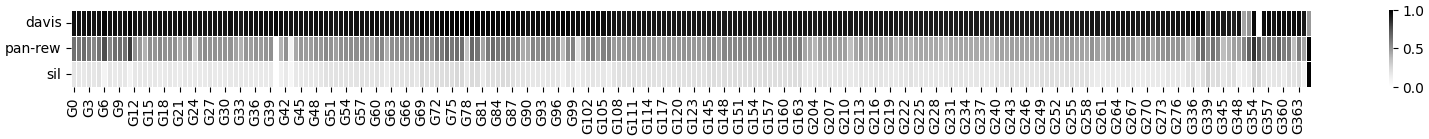

In [68]:
df_score = pd.DataFrame.from_dict(score_kernel, orient="index")
df_davis = pd.DataFrame.from_dict(davies_bouldin_kernel, orient="index")
df_sil = pd.DataFrame.from_dict(silhouette_dict_kernel, orient="index")
df_kernel = df_davis.join(df_score, lsuffix="davis", rsuffix="pan-rew").join(df_sil, rsuffix="sil")

df_kernel.rename(columns={"0pan-rew":"pan-rew", "0davis":"davis", 0: "sil"}, inplace=True)
df_kernel = pd.DataFrame(min_max_scalar.fit_transform(df_kernel), index = df_kernel.index, columns = df_kernel.columns) # Data Frame containing normalized data for each score

fig, ax = plt.subplots(figsize=(20,1))
sb.heatmap(df_kernel.transpose(), linewidth=.5, cmap="Greys", ax=ax, square=False, cbar_kws = {"shrink": 1})


[0, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 4, 3, 5, 3, 5, 5, 5, 4, 4, 4, 4, 5, 4, 4, 4, 4, 3, 4, 4, 5, 4, 3, 4, 4, 5, 4, 5, 4, 4, 3, 4, 4, 3, 5, 5, 4, 5, 3, 4, 4, 3, 3, 4, 4, 3, 4, 3, 4]
[3 3 3 3 3 3 3 3 3 3 2 1 2 2 2 2 2 0 2 2 0 0 2 1 0 0 2 2 2 0 0 0 2 0 2 0 0
 2 2 0 0 0 0 0 0 0 2 0 0 0 0 0 2 0 0 0 2 0 0 0 2 0 0 2 0 0 0 3 2 0 0 0 0 0]


<Axes: >

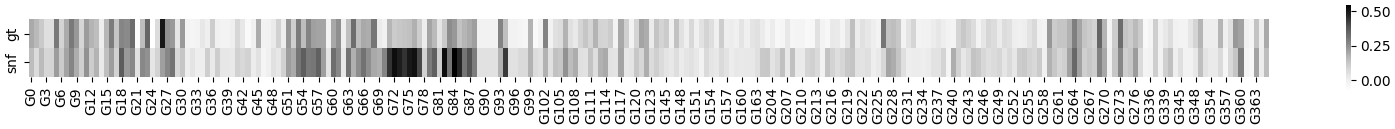

In [69]:
kernel_labels = {"ground_truth": ground_truth , "snf": fused_snf_labels } 
for name in list(graphs_74.keys()):
    kernel_labels[name] = labels_kernel_sc[name]


ami_kernel = []
for k1 in list(kernel_labels.keys())[:2]:
    g1 = kernel_labels[k1]
    print(g1)
    ami_with_g1 = []
    for k2 in list(kernel_labels.keys())[2:]:
        g2 = kernel_labels[k2]
        ami_score = ami(g1,g2)
        ami_with_g1.append(ami_score)
    
    ami_kernel.append(ami_with_g1)

fig, ax = plt.subplots(figsize=(20,0.75))
sb.heatmap(pd.DataFrame(ami_kernel, index = ["gt", "snf"], columns = list(graphs_74.keys())), ax = ax, cmap = "Greys", square=False, cbar_kws={"shrink": 1.5})

In [70]:
contribution_differences = []
df = pd.DataFrame(ami_kernel, index = ["gt", "snf"], columns = list(graphs_74.keys()))

for col in df.columns:
    gt_cont = df.loc["gt", col]
    snf_cont = df.loc["snf", col]
    contribution_differences.append(abs(gt_cont - snf_cont))

tolerance = np.percentile(contribution_differences, 35)
contribution = []


for col in df.columns:
    gt_cont = df.loc["gt", col]
    snf_cont = df.loc["snf", col]
    if abs(gt_cont - snf_cont) <= tolerance:
        contribution.append("equal")
    elif gt_cont > snf_cont:
        contribution.append("low")
    elif gt_cont < snf_cont:
        contribution.append("high")

In [71]:
cell_types = []
modules = []

for id, g in graphs_74.items():
    process = g.uns["module"]
    modality = g.uns["modality"]
    name = g.uns["name"]
    g.uns["process"] = process
    if modality == "citeRNA":
        ct = name.split("_")[1].split("-")[0]
        module = name.split("_")[1].split("-")[1]
        g.uns["module"] = module
        g.uns["cell-type"] = ct
        cell_types.append(ct)
        modules.append(module)
    elif modality == "adt" or modality == "cytof":
        ct = name.split("_")[1]
        g.uns["module"] = "None"
        g.uns["cell-type"] = ct
        modules.append("None")
        cell_types.append(ct)
    elif modality == "bulkRNA": 
        module = name.split("_")[1]
        g.uns["module"] = module
        g.uns["cell-type"] = "bulk"
        modules.append(module)
        cell_types.append("bulk")
    elif modality == "luminex": 
        g.uns["module"] = "None"
        g.uns["cell-type"] = "bulk"
        cell_types.append("bulk")
        modules.append("None")
    else: 
        g.uns["module"] = "None"
        g.uns["cell-type"] = "CD4"
        cell_types.append("CD4")
        modules.append("None")

/var/folders/d6/19fjtfkn2rb94y09ln9bk6m00000gn/T/ipykernel_1975/4077898350.py:8: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  g.uns["process"] = process
/var/folders/d6/19fjtfkn2rb94y09ln9bk6m00000gn/T/ipykernel_1975/4077898350.py:8: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  g.uns["process"] = process
/var/folders/d6/19fjtfkn2rb94y09ln9bk6m00000gn/T/ipykernel_1975/4077898350.py:8: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  g.uns["process"] = process
/var/folders/d6/19fjtfkn2rb94y09ln9bk6m00000gn/T/ipykernel_1975/4077898350.py:8: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  g.uns["process"] = process
/var/folders/d6/19fjtfkn2rb94y09ln9bk6m00000gn/T/ipykernel_1975/4077898350.py:8: ImplicitModificationWarning: Trying to modify attribute `._uns` of view

Starting plotting..
Starting calculating row orders..
Reordering rows..
Starting calculating col orders..
Reordering cols..
Plotting matrix..
Starting plotting HeatmapAnnotations
Plotting legends..
Incresing ncol
Incresing ncol
Incresing ncol
More than 3 cols is not supported
Legend too long, generating a new column..


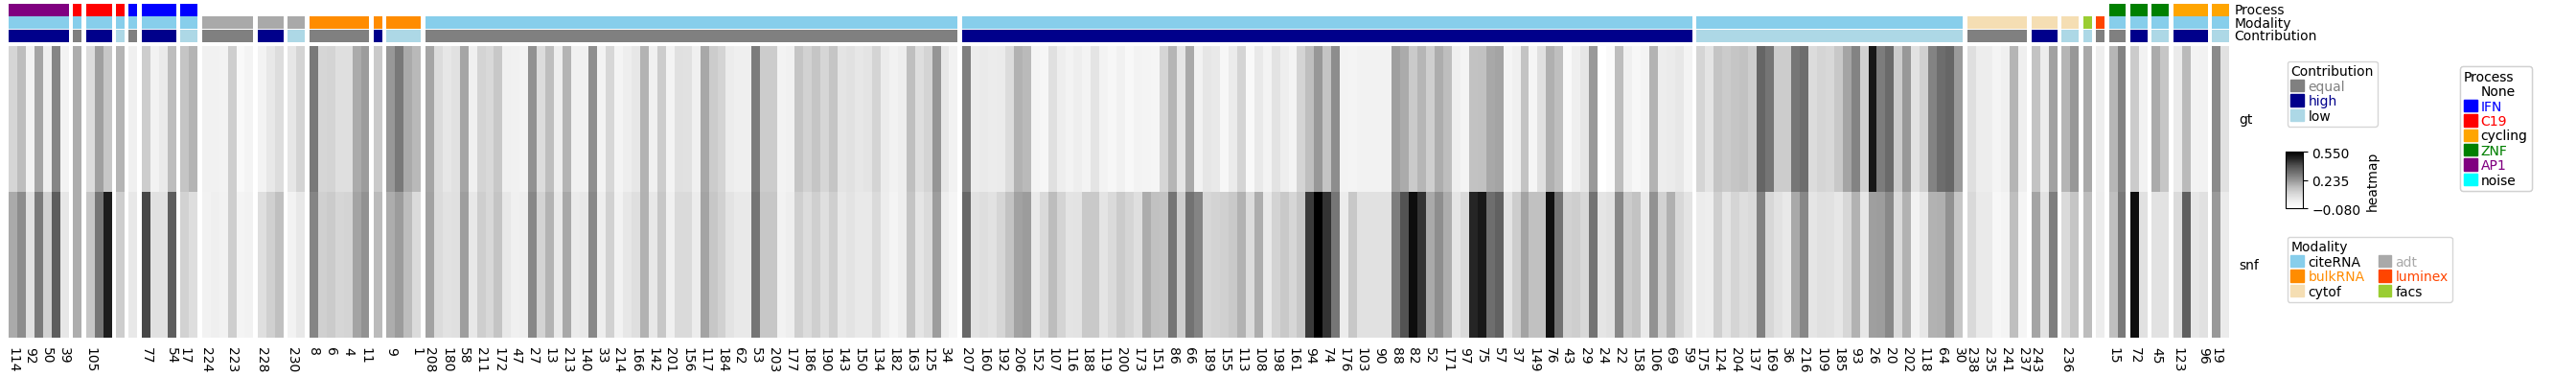

In [72]:
number_to_modality = {}
number_to_module = {}
number_to_contribution = {}
number_to_cell_type = {}
number_to_process = {}




for i, id in enumerate(graphs_74.keys()):

    number_to_modality[i] = graphs_74[id].uns["modality"]
    number_to_module[i] = graphs_74[id].uns["module"]
    number_to_contribution[i] = contribution[i]
    number_to_process[i] = graphs_74[id].uns["process"]
    number_to_cell_type[i] = graphs_74[id].uns["cell-type"]



df_column = pd.DataFrame(number_to_modality.values(), columns=["modality"] ).join(pd.DataFrame(number_to_contribution.values(), columns=["contribution"])).join(pd.DataFrame(number_to_process.values(), columns=["process"]))


col_colors_dict = {"process":{"None": "white", "IFN": "blue", "C19": "red", "cycling": "orange", "ZNF": "green", "AP1": "purple", "noise": "cyan" },
                  "modality":{"citeRNA":"skyblue", "bulkRNA": "darkorange" , "cytof": "wheat", "adt": "darkgray", "luminex": "orangered", "facs": "yellowgreen"},
                  "contribution":{"equal": "grey", "high": "darkblue", "low":"lightblue"}  }


col_ha= HeatmapAnnotation(Process=anno_simple(df_column.process,colors=col_colors_dict['process'],rasterized=True),
                          Modality=anno_simple(df_column.modality,colors=col_colors_dict['modality'],rasterized=True),
                          Contribution=anno_simple(df_column.contribution,colors=col_colors_dict['contribution'],rasterized=True),
                          axis=1)


fig, ax = plt.subplots(figsize=(30,4))
df = pd.DataFrame(ami_kernel, index = ["gt", "snf"],  columns = list(number_to_modality.keys())) # Data Frame containing normalized data for each score
ami_kernel_plt = ClusterMapPlotter(df, top_annotation=col_ha,
                     show_rownames=True,show_colnames=True,
                     row_dendrogram=False,col_dendrogram=False,
                     col_split=df_column.loc[:, ['process', 'modality', 'contribution']],
                     cmap='Greys',
                     rasterized=True,col_split_gap=1.2,legend=True,legend_anchor='ax_heatmap',legend_vpad=5,legend_hpad= 8, row_split_gap=1.2 )

Starting plotting..
Starting calculating row orders..
Reordering rows..
Starting calculating col orders..
Reordering cols..
Plotting matrix..
Starting plotting HeatmapAnnotations
Plotting legends..
Incresing ncol
Incresing ncol
More than 3 cols is not supported
Legend too long, generating a new column..


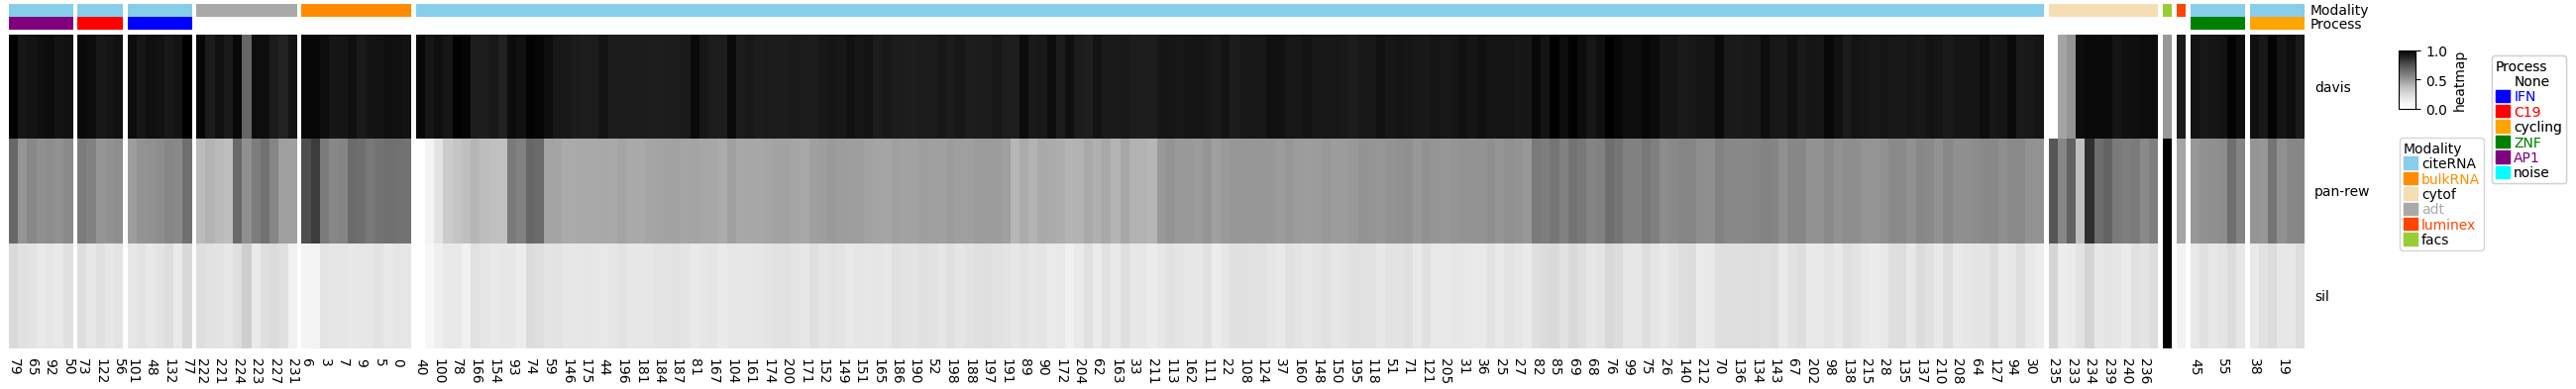

In [73]:
col_colors_dict = {"process":{"None": "white", "IFN": "blue", "C19": "red", "cycling": "orange", "ZNF": "green", "AP1": "purple", "noise": "cyan" },
                  "modality":{"citeRNA":"skyblue", "bulkRNA": "darkorange" , "cytof": "wheat", "adt": "darkgray", "luminex": "orangered", "facs": "yellowgreen"} }


col_ha= HeatmapAnnotation(Modality=anno_simple(df_column.modality,colors=col_colors_dict['modality'],rasterized=True),
                          Process=anno_simple(df_column.process,colors=col_colors_dict['process'],rasterized=True),
                          axis=1)

fig, ax = plt.subplots(figsize=(30,4))
df = pd.DataFrame(min_max_scalar.fit_transform(df_kernel), index = list(number_to_module.keys()), columns = df_kernel.columns) # Data Frame containing normalized data for each score
ami_kernel_plt = ClusterMapPlotter(df.transpose(), top_annotation=col_ha,
                     show_rownames=True,show_colnames=True,
                     row_dendrogram=False,col_dendrogram=False,
                     col_split=df_column.loc[:, ['process', 'modality']],
                     cmap='Greys',
                     rasterized=True,col_split_gap=1.2,legend=True,legend_anchor='ax_heatmap',legend_vpad=5,legend_hpad= 8, row_split_gap=1.2 )

### SNF - Corr - SC

In [74]:
fused_snf_corr = compute.snf(list(correlations.values()), K=6, t = 50)
first, second = compute.get_n_clusters(fused_snf_corr)
fused_snf_corr_labels = cluster.spectral_clustering(fused_snf_corr, n_clusters=first, n_init = 30)

tm = make_transition_matrix(fused_snf_corr)
fused_rw_score = random_walker_objective(tm)[2]

fused_silhouette_score = skl.metrics.silhouette_score(fused_snf_corr, fused_snf_corr_labels)
fused_davies_bouldin_score = skl.metrics.davies_bouldin_score(fused_snf_corr, fused_snf_corr_labels)

with open(os.path.join(fused_74, 'all_snf_corr.pickle'), 'wb') as f:
    pickle.dump(fused_snf_corr, f)

In [75]:
silhouette_dict_corr  = {}
davies_bouldin_corr = {}
score_corr = {}

for i, k in enumerate(graphs_74.keys()):
    loo = correlations.copy()
    loo.pop(k)

    loo_fused = compute.snf(list(loo.values()), K=6, t = 50)

    tm = make_transition_matrix(loo_fused)
    loo_rw_score = random_walker_objective(tm)[2]

    first, second = compute.get_n_clusters(loo_fused)
    loo_labels = cluster.spectral_clustering(loo_fused, n_clusters=first, n_init = 30)

    loo_silhouette_score = skl.metrics.silhouette_score(loo_fused, loo_labels)
    loo_davies_bouldin_score = skl.metrics.davies_bouldin_score(loo_fused, loo_labels)

    if loo_silhouette_score > fused_silhouette_score:
        silhouette_dict_corr[k] = -abs(fused_silhouette_score - loo_silhouette_score )
    else:
        silhouette_dict_corr[k] =  abs(fused_silhouette_score - loo_silhouette_score )


    if loo_davies_bouldin_score < fused_davies_bouldin_score:
        davies_bouldin_corr[k] = -abs(fused_davies_bouldin_score - loo_davies_bouldin_score )
    else:
        davies_bouldin_corr[k] =  abs(fused_davies_bouldin_score - loo_davies_bouldin_score )

    
    if loo_rw_score > fused_rw_score:
       score_corr[k] = -abs(loo_rw_score - fused_rw_score )
    else:
        score_corr[k] =  abs(loo_rw_score - fused_rw_score )

<Axes: >

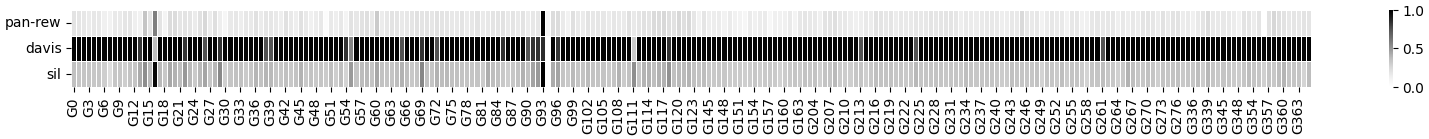

In [76]:
df_score = pd.DataFrame.from_dict(score_corr, orient="index")
df_davis = pd.DataFrame.from_dict(davies_bouldin_corr, orient="index")
df_sil = pd.DataFrame.from_dict(silhouette_dict_corr, orient="index")
df_kernel = df_score.join(df_davis, rsuffix="davis", lsuffix="pan-rew").join(df_sil, rsuffix="sil")

df_kernel.rename(columns={"0pan-rew":"pan-rew", "0davis":"davis", 0: "sil"}, inplace=True)
df_kernel = pd.DataFrame(min_max_scalar.fit_transform(df_kernel), index = df_kernel.index, columns = df_kernel.columns) # Data Frame containing normalized data for each score

fig, ax = plt.subplots(figsize=(20,1))
sb.heatmap(df_kernel.transpose(), linewidth=.5, cmap="Greys", ax=ax, square=False, cbar_kws = {"shrink": 1})

/Users/shakiba/Desktop/thesis.tmp/code/aggregated_patient_info/aggregated_patient_info/lib/python3.11/site-packages/sklearn/manifold/_spectral_embedding.py:247: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/Users/shakiba/Desktop/thesis.tmp/code/aggregated_patient_info/aggregated_patient_info/lib/python3.11/site-packages/sklearn/manifold/_spectral_embedding.py:247: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/Users/shakiba/Desktop/thesis.tmp/code/aggregated_patient_info/aggregated_patient_info/lib/python3.11/site-packages/sklearn/manifold/_spectral_embedding.py:247: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/Users/shakiba/Desktop/thesis.tmp/code/aggregated_patient_info/aggregated_patient_inf

<Axes: >

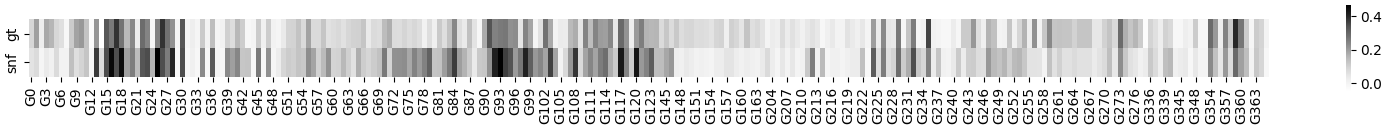

In [77]:
corr_labels = {"ground_truth": ground_truth, "snf": fused_snf_corr_labels } 
for name in list(graphs_74.keys()):
    g = correlations[name]
    g = min_max_scalar.fit_transform(g)
 
    first, second = compute.get_n_clusters(g)
    l = cluster.spectral_clustering(g, n_clusters=first, n_init = 30)
    corr_labels[name] = l


ami_corr = []
for k1 in list(corr_labels.keys())[:2]:
    g1 = corr_labels[k1]
    ami_with_g1 = []
    for k2 in list(corr_labels.keys())[2:]:
        g2 = corr_labels[k2]
        ami_score = ami(g1,g2)
        ami_with_g1.append(ami_score)
    
    ami_corr.append(ami_with_g1)

fig, ax = plt.subplots(figsize=(20,0.75))
sb.heatmap(pd.DataFrame(ami_corr, index = ["gt", "snf"], columns = list(graphs_74.keys())), ax = ax, cmap = "Greys", square=False, cbar_kws={"shrink": 1.5})

### WA - KNN - Leiden

In [78]:
fused_wa = None
for id in knn_PSNs.keys():
    to_add = weights[id] * knn_PSNs[id]
    if np.isnan(to_add).any():
        nan_locs = np.argwhere(np.isnan(to_add))
        for loc in nan_locs:
            to_add[loc[0], loc[1]] = 0

    if fused_wa is None:
        fused_wa = to_add
    else:
        fused_wa = fused_wa + to_add

ad_wa_knn =ad.AnnData(fused_wa)
ad_wa_knn.obsp["connectivities"] = fused_wa
scp.tl.leiden(ad_wa_knn, resolution=1, adjacency=fused_wa, directed=False, use_weights=True)
fused_wa_labels = list(ad_wa_knn.obs.leiden)


tm = make_transition_matrix(fused_wa)
fused_rw_score = random_walker_objective(tm)[2]

fused_silhouette_score = skl.metrics.silhouette_score(fused_wa, fused_wa_labels)
fused_davies_bouldin_score = skl.metrics.davies_bouldin_score(fused_wa, fused_wa_labels)

with open(os.path.join(fused_74, 'all_wa_knn.pickle'), 'wb') as f:
    pickle.dump(fused_wa, f)

In [79]:
silhouette_dict_knn  = {}
davies_bouldin_knn = {}
score_knn = {}

for i, k in enumerate(graphs_74.keys()):
    loo = knn_PSNs.copy()
    loo.pop(k)

    loo_fused = None
    for id in loo.keys():
        to_add =  weights[id] * knn_PSNs[id]
        if np.isnan(to_add).any():
            nan_locs = np.argwhere(np.isnan(to_add))
            for loc in nan_locs:
                to_add[loc[0], loc[1]] = 0

        if loo_fused is None:
            loo_fused = to_add
        else:
            loo_fused = loo_fused + to_add

    ad_wa_knn =ad.AnnData(loo_fused)
    ad_wa_knn.obsp["connectivities"] = loo_fused
    scp.tl.leiden(ad_wa_knn, resolution=1, adjacency=loo_fused, directed=False, use_weights=True)
    loo_labels = list(ad_wa_knn.obs.leiden)


    tm = make_transition_matrix(loo_fused)
    loo_rw_score = random_walker_objective(tm)[2]

    loo_silhouette_score = skl.metrics.silhouette_score(loo_fused, loo_labels)
    loo_davies_bouldin_score = skl.metrics.davies_bouldin_score(loo_fused, loo_labels)

    if loo_silhouette_score > fused_silhouette_score:
        silhouette_dict_knn[k] = -abs(fused_silhouette_score - loo_silhouette_score )
    else:
        silhouette_dict_knn[k] =  abs(fused_silhouette_score - loo_silhouette_score )


    if loo_davies_bouldin_score < fused_davies_bouldin_score:
        davies_bouldin_knn[k] = -abs(fused_davies_bouldin_score - loo_davies_bouldin_score )
    else:
        davies_bouldin_knn[k] =  abs(fused_davies_bouldin_score - loo_davies_bouldin_score )

    
    if loo_rw_score > fused_rw_score:
       score_knn[k] = -abs(loo_rw_score - fused_rw_score )
    else:
        score_knn[k] =  abs(loo_rw_score - fused_rw_score )

<Axes: >

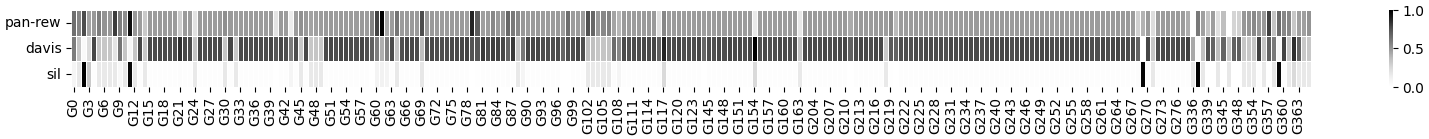

In [80]:
df_score = pd.DataFrame.from_dict(score_knn, orient="index")
df_davis = pd.DataFrame.from_dict(davies_bouldin_knn, orient="index")
df_sil = pd.DataFrame.from_dict(silhouette_dict_knn, orient="index")
df_knn = df_score.join(df_davis, rsuffix="davis", lsuffix="pan-rew").join(df_sil, rsuffix="sil")

df_knn.rename(columns={"0pan-rew":"pan-rew", "0davis":"davis", 0: "sil"}, inplace=True)
df_knn = pd.DataFrame(min_max_scalar.fit_transform(df_knn), index = df_knn.index, columns = df_knn.columns) # Data Frame containing normalized data for each score

fig, ax = plt.subplots(figsize=(20,1))
sb.heatmap(df_knn.transpose(), linewidth=.5, cmap="Greys", ax=ax, square=False, cbar_kws = {"shrink": 1})


<Axes: >

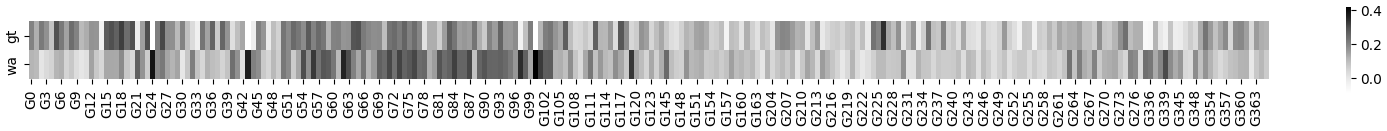

In [81]:
knn_labels = {"ground_truth": ground_truth, "wa": fused_wa_labels } 
for name in list(graphs_74.keys()):
    knn_labels[name] = labels_knn_leiden[name]


ami_knn = []
for k1 in list(knn_labels.keys())[:2]:
    g1 = knn_labels[k1]
    ami_with_g1 = []
    for k2 in list(knn_labels.keys())[2:]:
        g2 = knn_labels[k2]
        ami_score = ami(g1,g2)
        ami_with_g1.append(ami_score)
    
    ami_knn.append(ami_with_g1)

fig, ax = plt.subplots(figsize=(20,0.75))
sb.heatmap(pd.DataFrame(ami_knn, index = ["gt", "wa"], columns = list(graphs_74.keys())), ax = ax, cmap = "Greys", square=False, cbar_kws={"shrink": 1.5})

# Modality Contributions

## KNN - WA

In [82]:
fused_citeRNA = None
for psn in citeRNA_knn_74.values():
    to_add =  psn * (1/len(citeRNA_knn_74))
    if np.isnan(to_add).any():
        nan_locs = np.argwhere(np.isnan(to_add))
        for loc in nan_locs:
            to_add[loc[0], loc[1]] = 0
    if fused_citeRNA is None:
        fused_citeRNA = to_add
    else:
        fused_citeRNA = to_add + fused_citeRNA

ad_wa_knn =ad.AnnData(fused_citeRNA)
ad_wa_knn.obsp["connectivities"] = fused_citeRNA
scp.tl.leiden(ad_wa_knn, resolution=1, adjacency=fused_citeRNA, directed=False, use_weights=True)
citeRNA_labels = list(ad_wa_knn.obs.leiden)
print(set(citeRNA_labels))

fused_cytof = None
for psn in cytof_knn_74.values():
    to_add = psn * (1/len(cytof_knn_74))
    if np.isnan(to_add).any():
        nan_locs = np.argwhere(np.isnan(to_add))
        for loc in nan_locs:
            to_add[loc[0], loc[1]] = 0
    if fused_cytof is None:
        fused_cytof = to_add
    else:
        fused_cytof = to_add + fused_cytof

ad_wa_knn =ad.AnnData(fused_cytof)
ad_wa_knn.obsp["connectivities"] = fused_cytof
scp.tl.leiden(ad_wa_knn, resolution=1, adjacency=fused_cytof, directed=False, use_weights=True)
cytof_labels = list(ad_wa_knn.obs.leiden)
print(set(cytof_labels))

fused_bulkRNA = None
for psn in bulkRNA_knn_74.values():
    to_add =  psn * (1/len(bulkRNA_knn_74))
    if np.isnan(to_add).any():
        nan_locs = np.argwhere(np.isnan(to_add))
        for loc in nan_locs:
            to_add[loc[0], loc[1]] = 0
    if fused_bulkRNA is None:
        fused_bulkRNA = to_add
    else:
        fused_bulkRNA = to_add + fused_bulkRNA

ad_wa_knn =ad.AnnData(fused_bulkRNA)
ad_wa_knn.obsp["connectivities"] = fused_bulkRNA
scp.tl.leiden(ad_wa_knn, resolution=1, adjacency=fused_bulkRNA, directed=False, use_weights=True)
bulkRNA_labels = list(ad_wa_knn.obs.leiden)
print(set(bulkRNA_labels))

fused_adt = None
for psn in adt_knn_74.values():
    to_add =  psn * (1/len(adt_knn_74))
    if np.isnan(to_add).any():
        nan_locs = np.argwhere(np.isnan(to_add))
        for loc in nan_locs:
            to_add[loc[0], loc[1]] = 0
    if fused_adt is None:
        fused_adt = to_add
    else:
        fused_adt = to_add + fused_adt

ad_wa_knn =ad.AnnData(fused_adt)
ad_wa_knn.obsp["connectivities"] = fused_adt
scp.tl.leiden(ad_wa_knn, resolution=1, adjacency=fused_adt, directed=False, use_weights=True)
adt_labels = list(ad_wa_knn.obs.leiden)
print(set(adt_labels))

fused_luminex = list(luminex_kernel_74.values())[0]


ad_wa_knn =ad.AnnData(fused_luminex)
ad_wa_knn.obsp["connectivities"] = fused_luminex
scp.tl.leiden(ad_wa_knn, resolution=0.002, adjacency=fused_luminex, directed=False, use_weights=True)
luminex_labels = list(ad_wa_knn.obs.leiden)
print(set(luminex_labels))


fused_facs = list(facs_kernel_74.values())[0]

ad_wa_knn =ad.AnnData(fused_facs)
ad_wa_knn.obsp["connectivities"] = fused_facs
scp.tl.leiden(ad_wa_knn, resolution=0.005, adjacency=fused_facs, directed=False, use_weights=True)
facs_labels = list(ad_wa_knn.obs.leiden)
print(set(facs_labels))


fused = (fused_citeRNA + fused_cytof + fused_bulkRNA + fused_adt + fused_facs + fused_luminex)/ 5
ad_wa_knn =ad.AnnData(fused)
ad_wa_knn.obsp["connectivities"] = fused
scp.tl.leiden(ad_wa_knn, resolution=1, adjacency=fused, directed=False, use_weights=True)
fused_labels = list(ad_wa_knn.obs.leiden)
print(set(fused_labels))


{'1', '0', '2'}
{'1', '2', '4', '5', '3', '0'}
{'1', '6', '2', '4', '5', '3', '0'}
{'1', '2', '4', '3', '0'}
{'1', '6', '2', '7', '4', '5', '3', '0'}
{'1', '2', '4', '5', '3', '0'}
{'1', '6', '2', '4', '5', '3', '0'}


In [66]:
with open(os.path.join(fused_74, 'citeRNA_wa_knn.pickle'), 'wb') as f:
    pickle.dump(fused_citeRNA, f)

with open(os.path.join(fused_74, 'cytof_wa_knn.pickle'), 'wb') as f:
    pickle.dump(fused_cytof, f)

with open(os.path.join(fused_74, 'bulkRNA_wa_knn.pickle'), 'wb') as f:
    pickle.dump(fused_bulkRNA, f)

with open(os.path.join(fused_74, 'adt_wa_knn.pickle'), 'wb') as f:
    pickle.dump(fused_adt, f)

with open(os.path.join(fused_74, 'facs_wa_knn.pickle'), 'wb') as f:
    pickle.dump(fused_facs, f)

with open(os.path.join(fused_74, 'luminex_wa_knn.pickle'), 'wb') as f:
    pickle.dump(fused_luminex, f)

<Axes: >

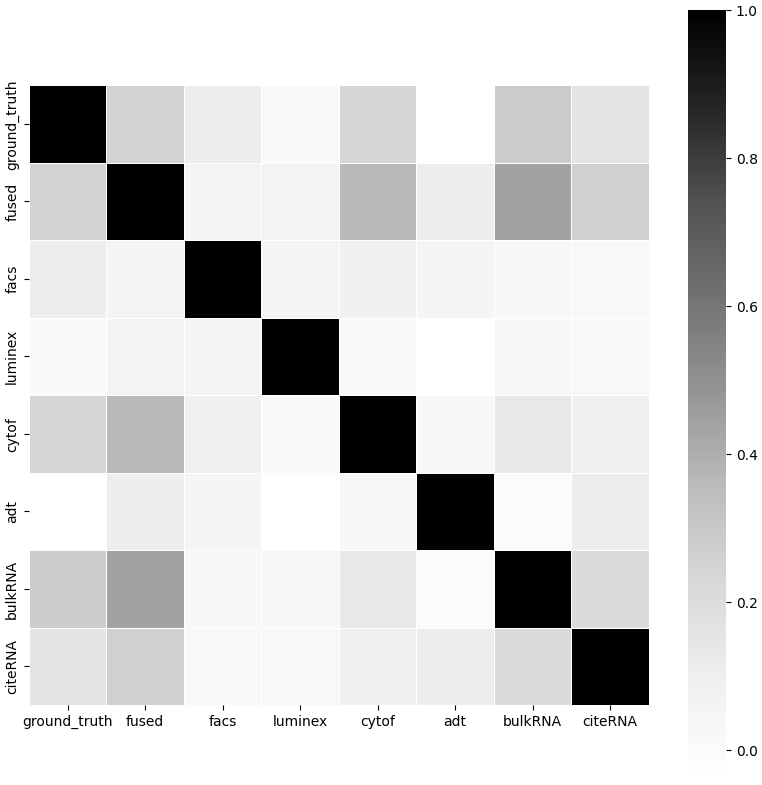

In [83]:
label_collection = {"ground_truth": ground_truth, "fused": fused_labels, "facs": facs_labels, "luminex": luminex_labels, "cytof": cytof_labels, "adt": adt_labels,  "bulkRNA": bulkRNA_labels, "citeRNA": citeRNA_labels  }

ami_modalities = []
for l1 in label_collection.values():
    ami_with_l1 = []
    for l2 in label_collection.values():
        ami_with_l1.append(ami(l1,l2))
    ami_modalities.append(ami_with_l1)


fig, ax = plt.subplots(figsize=(10,10))
sb.heatmap(pd.DataFrame(ami_modalities, columns = list(label_collection.keys()), index = list(label_collection.keys()) ), linewidth=.5, cmap="Greys", ax=ax, square=True, cbar_kws = {"shrink": 1})

## Kernel - SNF

In [84]:
fused_citeRNA = compute.snf(list(citeRNA_kernel_74.values()), K=6, t = 50)
first, second = compute.get_n_clusters(fused_citeRNA)
citeRNA_labels = cluster.spectral_clustering(fused_citeRNA, n_clusters=first, n_init = 30)

fused_bulkRNA = compute.snf(list(bulkRNA_kernel_74.values()), K=6, t = 50)
first, second = compute.get_n_clusters(fused_bulkRNA)
bulkRNA_labels = cluster.spectral_clustering(fused_bulkRNA, n_clusters=first, n_init = 30)

fused_adt = compute.snf(list(adt_kernel_74.values()), K=6, t = 50)
first, second = compute.get_n_clusters(fused_adt)
adt_labels = cluster.spectral_clustering(fused_adt, n_clusters=first, n_init = 30)

fused_cytof = compute.snf(list(cytof_kernel_74.values()), K=6, t = 50)
first, second = compute.get_n_clusters(fused_cytof)
cytof_labels = cluster.spectral_clustering(fused_cytof, n_clusters=first, n_init = 30)

fused_luminex = list(luminex_kernel_74.values())[0]
first, second = compute.get_n_clusters(fused_luminex)
luminex_labels = cluster.spectral_clustering(fused_luminex, n_clusters=first, n_init = 30)

fused_facs = list(facs_kernel_74.values())[0]
first, second = compute.get_n_clusters(fused_facs)
facs_labels = cluster.spectral_clustering(fused_facs, n_clusters=first, n_init = 30)

fused = compute.snf([fused_facs, fused_luminex, fused_citeRNA, fused_bulkRNA, fused_adt, fused_cytof], K=6, t = 50)
first, second = compute.get_n_clusters(fused)
fused_labels = cluster.spectral_clustering(fused, n_clusters=first, n_init = 30)



In [69]:
with open(os.path.join(fused_74, 'citeRNA_snf_kernel.pickle'), 'wb') as f:
    pickle.dump(fused_citeRNA, f)

with open(os.path.join(fused_74, 'cytof_snf_kernel.pickle'), 'wb') as f:
    pickle.dump(fused_cytof, f)

with open(os.path.join(fused_74, 'bulkRNA_snf_kernel.pickle'), 'wb') as f:
    pickle.dump(fused_bulkRNA, f)

with open(os.path.join(fused_74, 'adt_snf_kernel.pickle'), 'wb') as f:
    pickle.dump(fused_adt, f)

with open(os.path.join(fused_74, 'facs_snf_kernel.pickle'), 'wb') as f:
    pickle.dump(fused_facs, f)

with open(os.path.join(fused_74, 'luminex_snf_kernel.pickle'), 'wb') as f:
    pickle.dump(fused_luminex, f)

<Axes: >

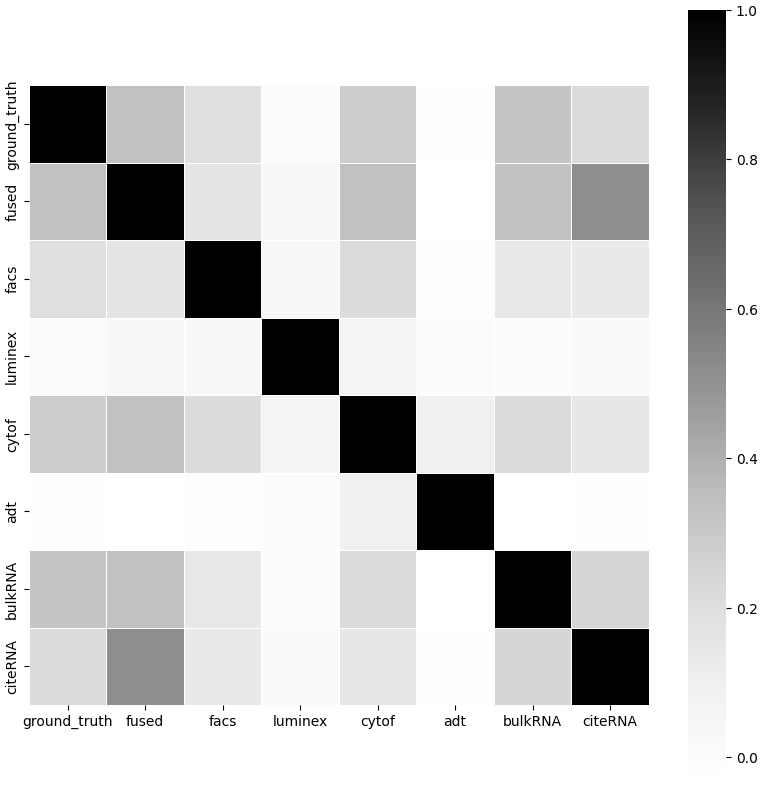

In [85]:
label_collection = {"ground_truth": ground_truth, "fused": fused_labels, "facs": facs_labels, "luminex": luminex_labels, "cytof": cytof_labels, "adt": adt_labels,  "bulkRNA": bulkRNA_labels, "citeRNA": citeRNA_labels  }

ami_modalities = []
for l1 in label_collection.values():
    ami_with_l1 = []
    for l2 in label_collection.values():
        ami_with_l1.append(ami(l1,l2))
    ami_modalities.append(ami_with_l1)


fig, ax = plt.subplots(figsize=(10,10))
sb.heatmap(pd.DataFrame(ami_modalities, columns = list(label_collection.keys()), index = list(label_collection.keys()) ), linewidth=.5, cmap="Greys", ax=ax, square=True, cbar_kws = {"shrink": 1})

# Matrix Similarities

## AMI

### Correlation

<Axes: >

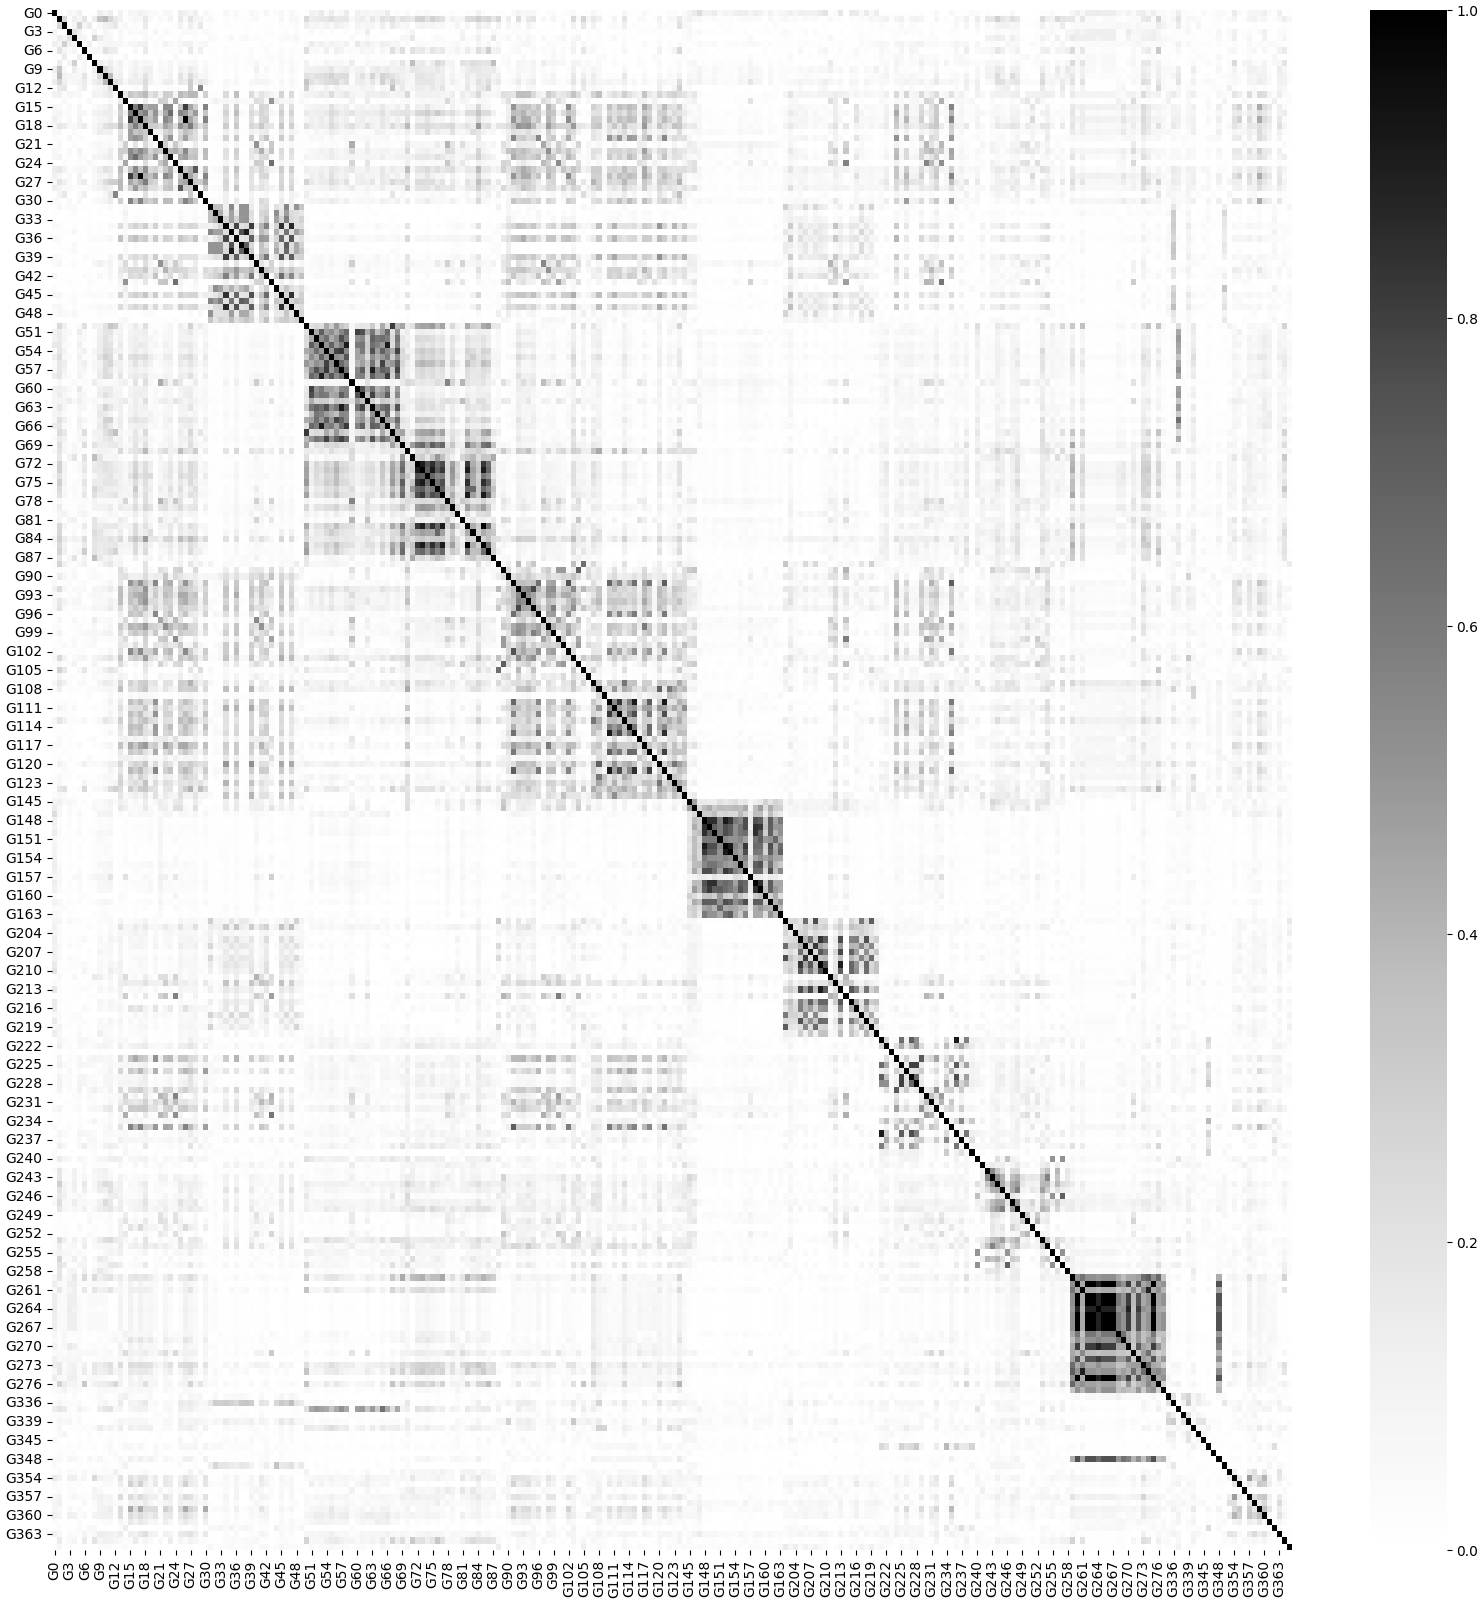

In [86]:
corr_ami = []

for k1 in list(corr_labels.keys())[2:]:
    g1 = corr_labels[k1]
    ami_with_g1 = []
    for k2 in list(corr_labels.keys())[2:]:
        g2 = corr_labels[k2]
        ami_score = ami(g1,g2)
        ami_with_g1.append(ami_score)
    
    corr_ami.append(ami_with_g1)

corr_ami = np.array(corr_ami)
corr_ami = min_max_scalar.fit_transform(corr_ami)
corr_ami_with_names = pd.DataFrame(corr_ami, index= list(corr_labels.keys())[2:], columns=list(corr_labels.keys())[2:])
corr_ami = pd.DataFrame(corr_ami)

fig, ax = plt.subplots(figsize=(20,20))
sb.heatmap(corr_ami_with_names, ax = ax, cmap = "Greys")

### KNN

In [79]:
knn_ami = []

for k1, g1 in labels_knn_leiden.items():
    ami_with_g1 = []
    for k2, g2 in labels_knn_leiden.items():
        ami_score = ami(g1,g2)
        ami_with_g1.append(ami_score)
    
    knn_ami.append(ami_with_g1)

knn_ami = np.array(knn_ami)
knn_ami = min_max_scalar.fit_transform(knn_ami)
knn_ami_with_names = pd.DataFrame(knn_ami, index= all_dict["all_names"], columns= all_dict["all_names"])
knn_ami = pd.DataFrame(knn_ami)

<Axes: >

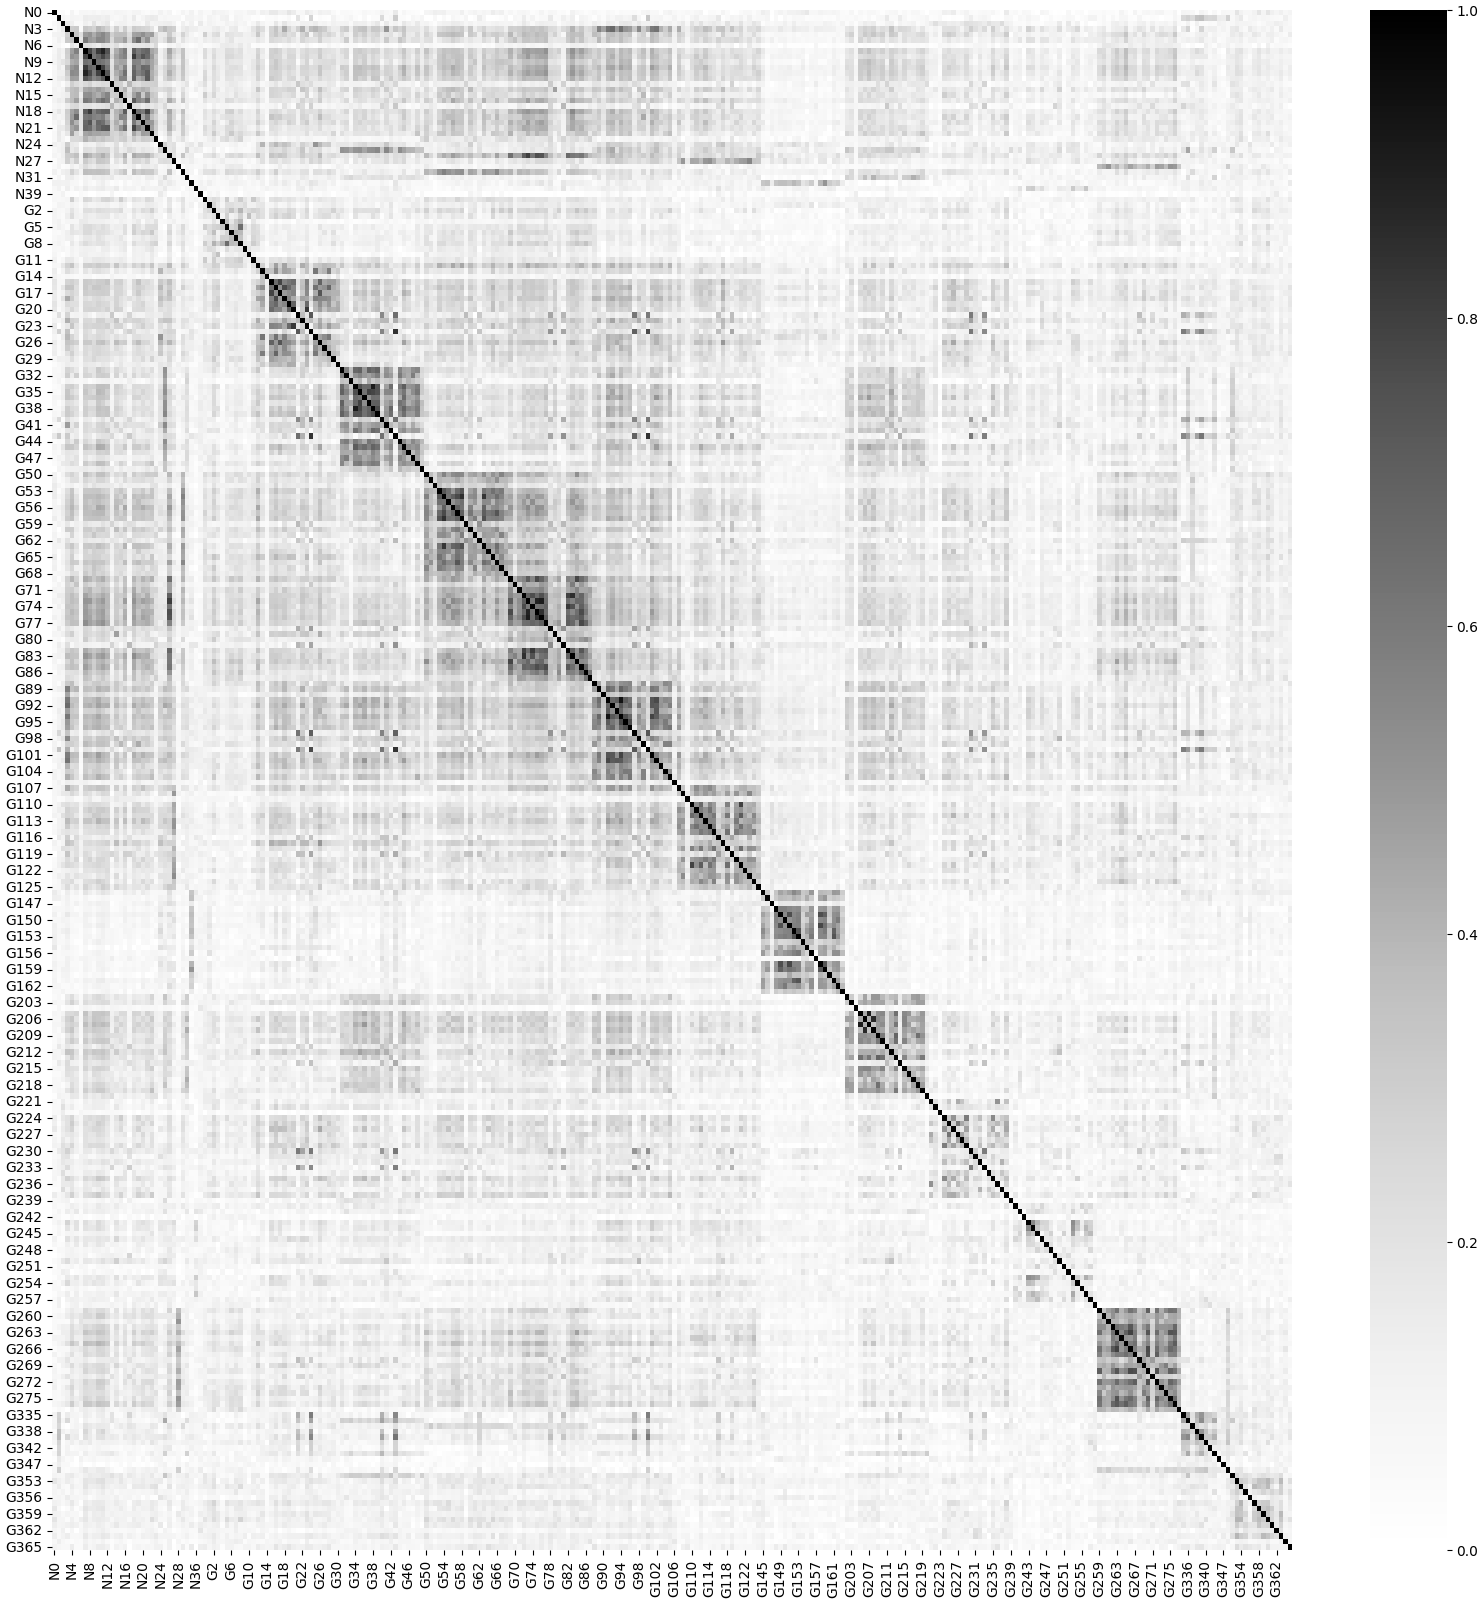

In [80]:
fig, ax = plt.subplots(figsize=(20,20))
sb.heatmap(knn_ami_with_names, ax = ax, cmap = "Greys")

### Kernel

In [87]:
kernel_ami = []

for k1, g1 in labels_kernel_sc.items():
    ami_with_g1 = []
    for k2, g2 in labels_kernel_sc.items():
        ami_score = ami(g1,g2)
        ami_with_g1.append(ami_score)
    
    kernel_ami.append(ami_with_g1)

kernel_ami = np.array(kernel_ami)
kernel_ami = min_max_scalar.fit_transform(kernel_ami)
kernel_ami_with_names = pd.DataFrame(kernel_ami, index= all_dict["all_names"], columns= all_dict["all_names"])
kernel_ami = pd.DataFrame(kernel_ami)

<Axes: >

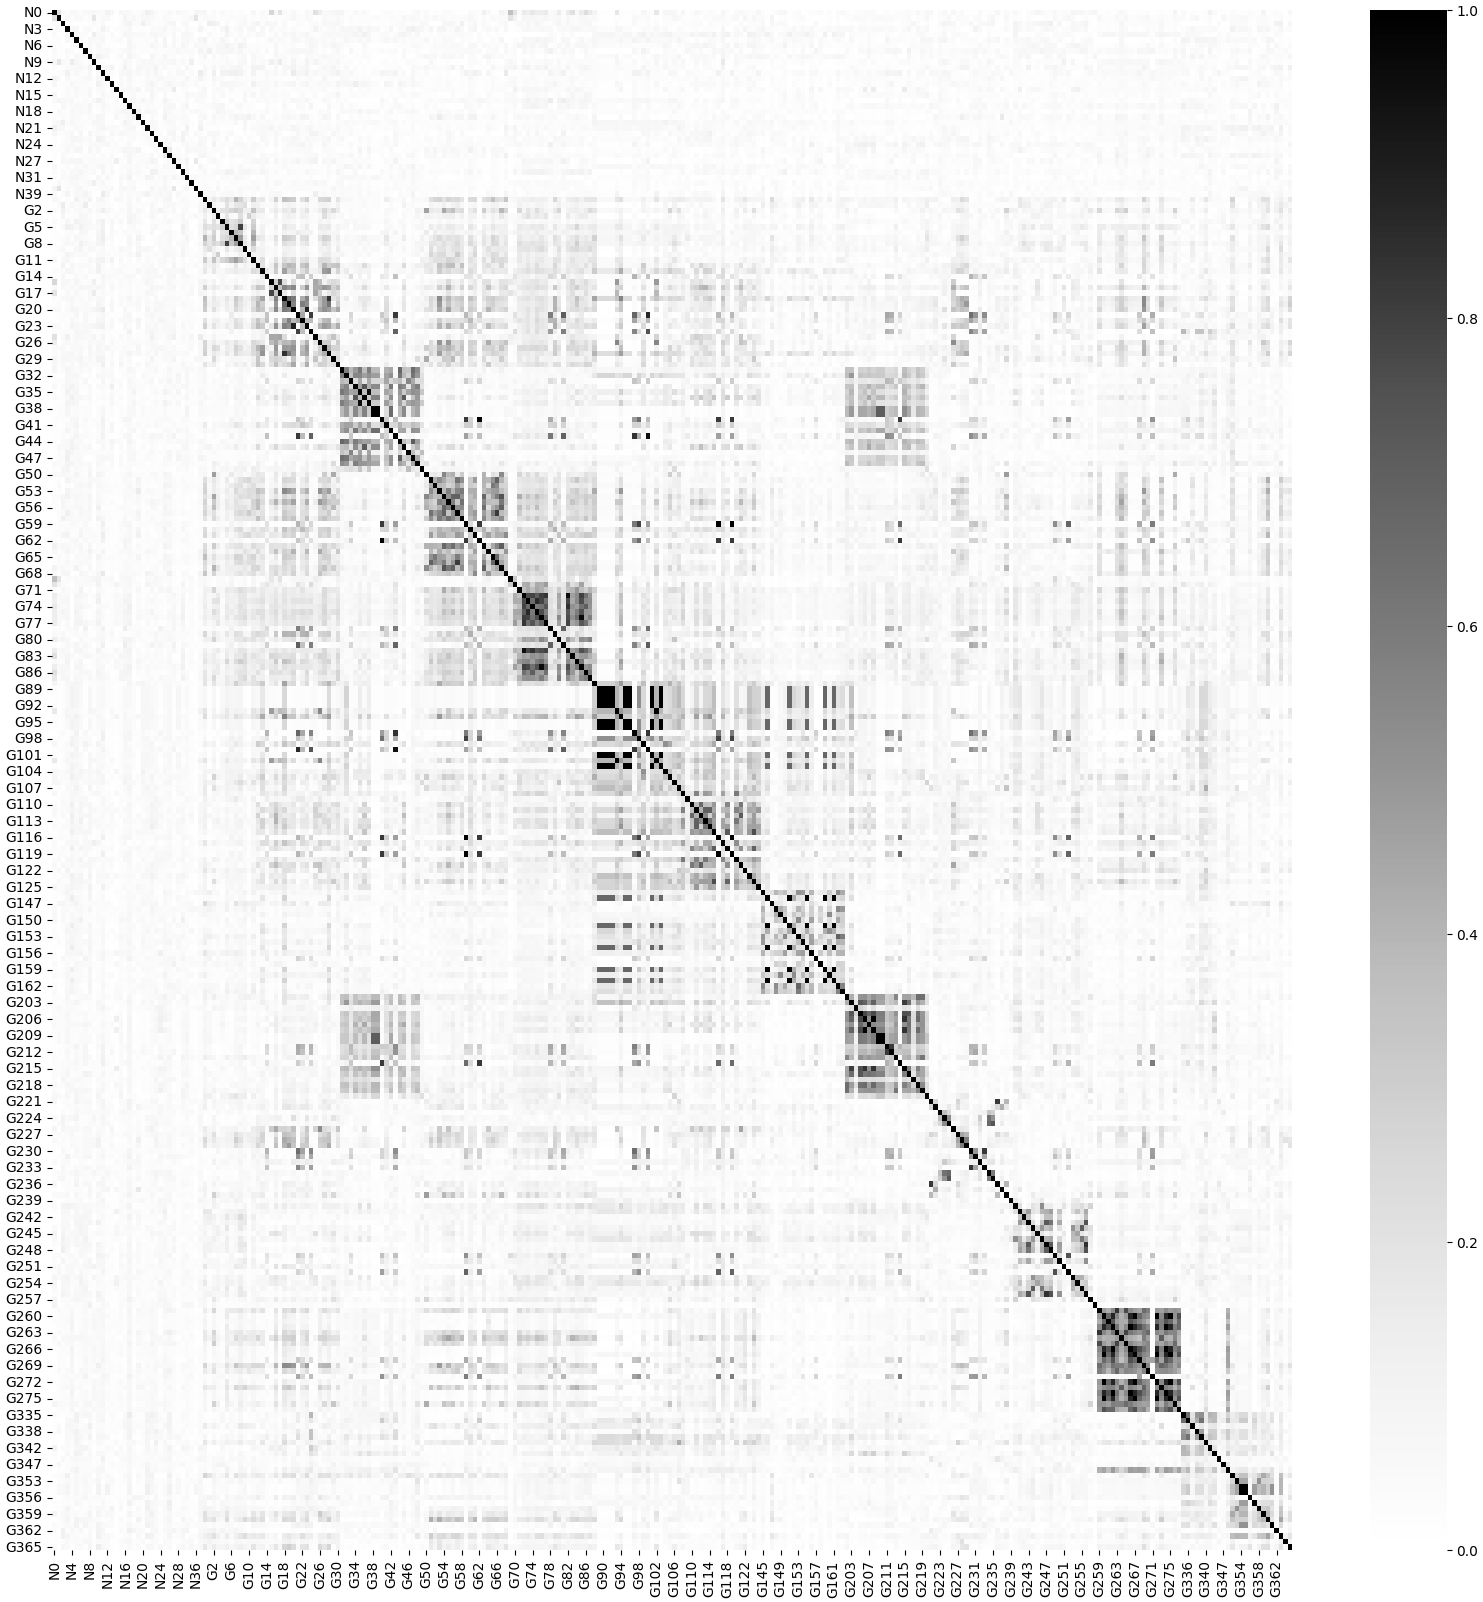

In [88]:
fig, ax = plt.subplots(figsize=(20,20))
sb.heatmap(kernel_ami_with_names, ax = ax, cmap = "Greys")

## Forbenius Norm

### Correlation

<Axes: >

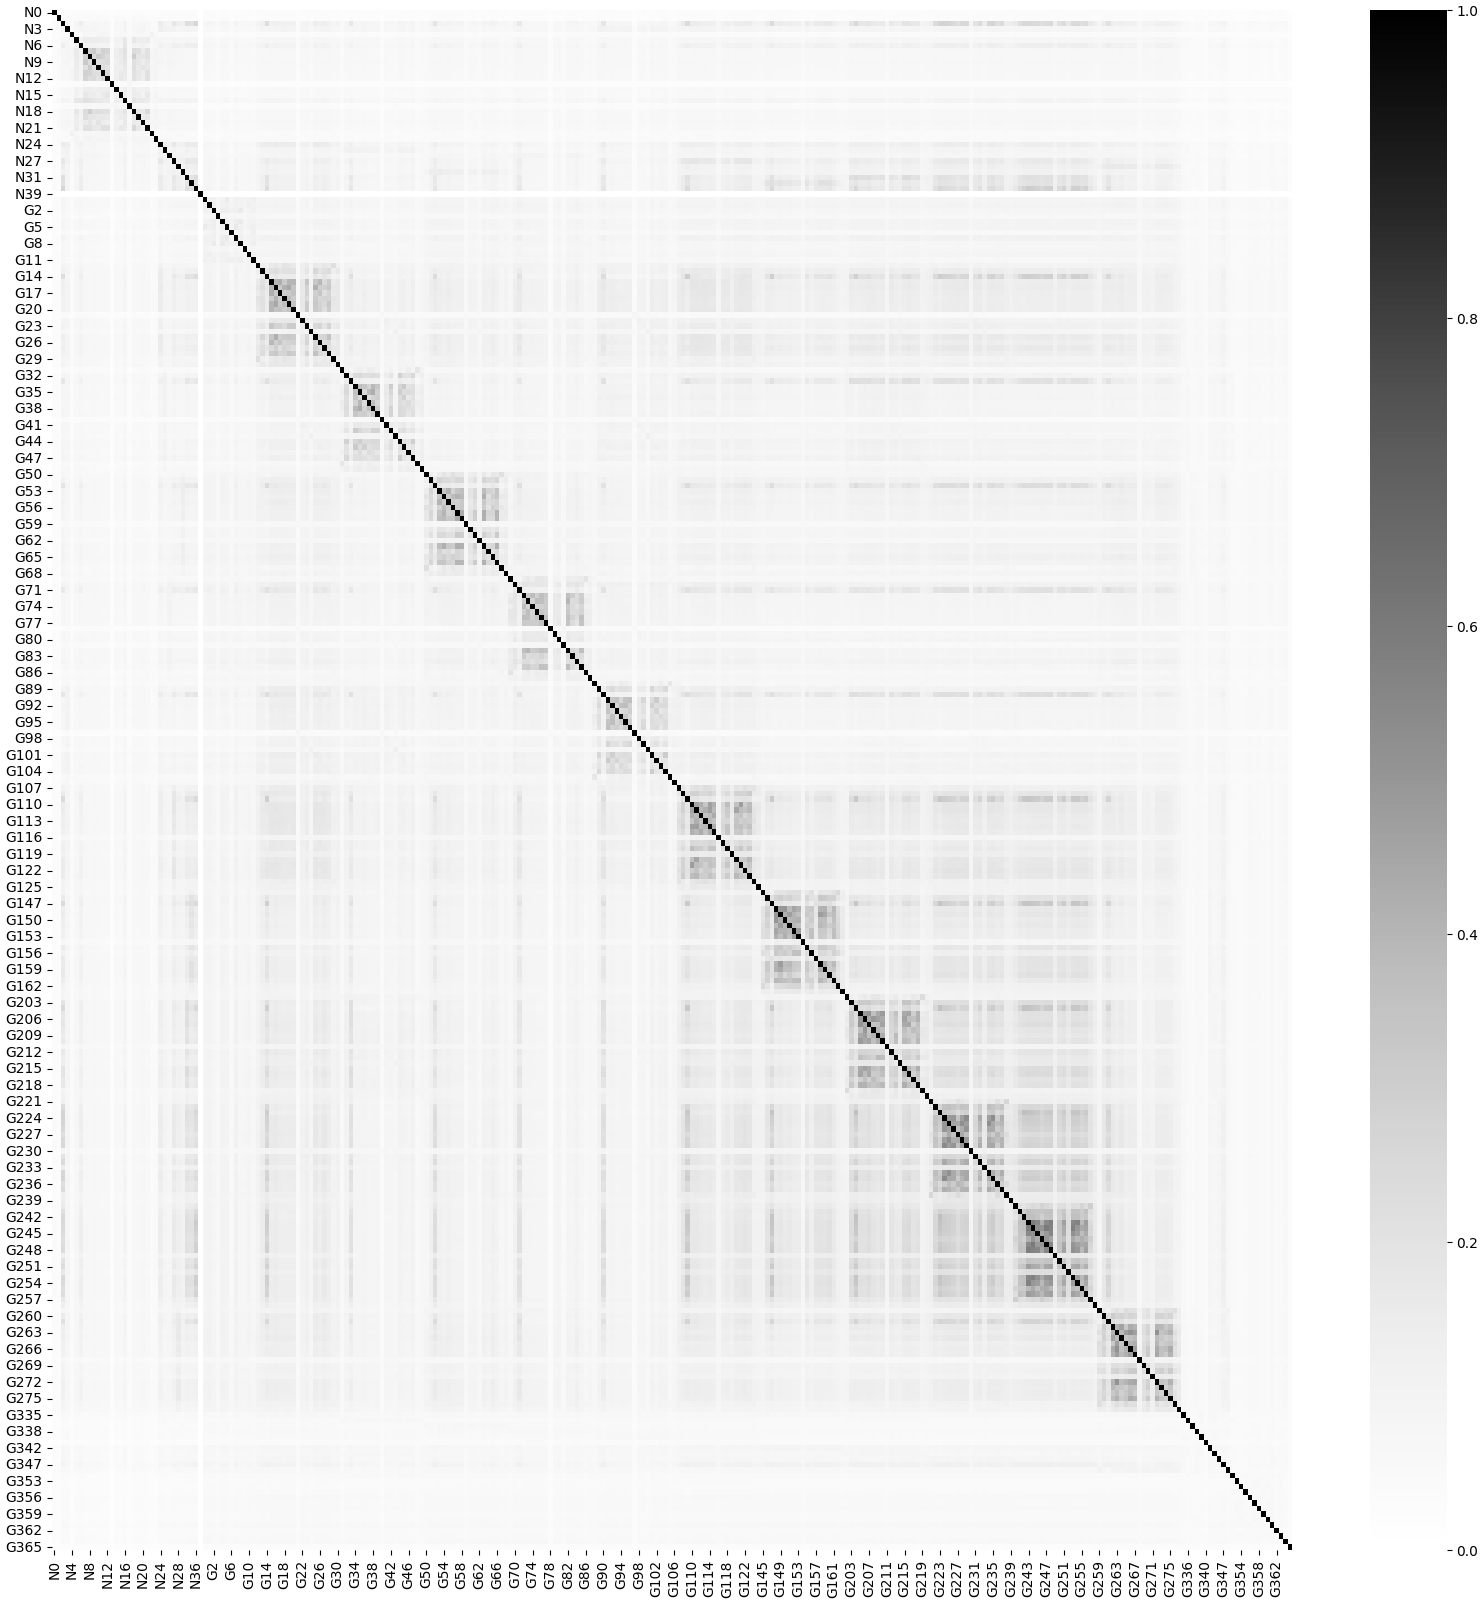

In [83]:
correlation_forb_norm = []

for g1 in all_dict["all_correlations"]:
    forb_norm_with_g1 = []
    for g2 in all_dict["all_correlations"]:
        diff = g1 - g2
        norm = np.linalg.norm(diff)
        forb_norm_with_g1.append(1/ (1+ norm))

    correlation_forb_norm.append(forb_norm_with_g1)

correlation_forb_norm = np.array(correlation_forb_norm)
correlation_forb_norm = min_max_scalar.fit_transform(correlation_forb_norm)
correlation_forb_norm_with_names = pd.DataFrame(correlation_forb_norm, index= all_dict["all_names"], columns= all_dict["all_names"])
correlation_forb_norm = pd.DataFrame(correlation_forb_norm)

fig, ax = plt.subplots(figsize=(20,20))
sb.heatmap(correlation_forb_norm_with_names, ax = ax, cmap = "Greys")

### KNN

In [84]:
knn_forb_norm = []

for g1 in all_dict["all_psns"]:
    forb_norm_with_g1 = []
    for g2 in all_dict["all_psns"]:
        diff = g1 - g2
        norm = np.linalg.norm(diff)
        forb_norm_with_g1.append(1/ (1+ norm))

    knn_forb_norm.append(forb_norm_with_g1)

knn_forb_norm = np.array(knn_forb_norm)
knn_forb_norm = min_max_scalar.fit_transform(knn_forb_norm)
knn_forb_norm_with_names = pd.DataFrame(knn_forb_norm, index= all_dict["all_names"], columns= all_dict["all_names"])
knn_forb_norm = pd.DataFrame(knn_forb_norm)

<Axes: >

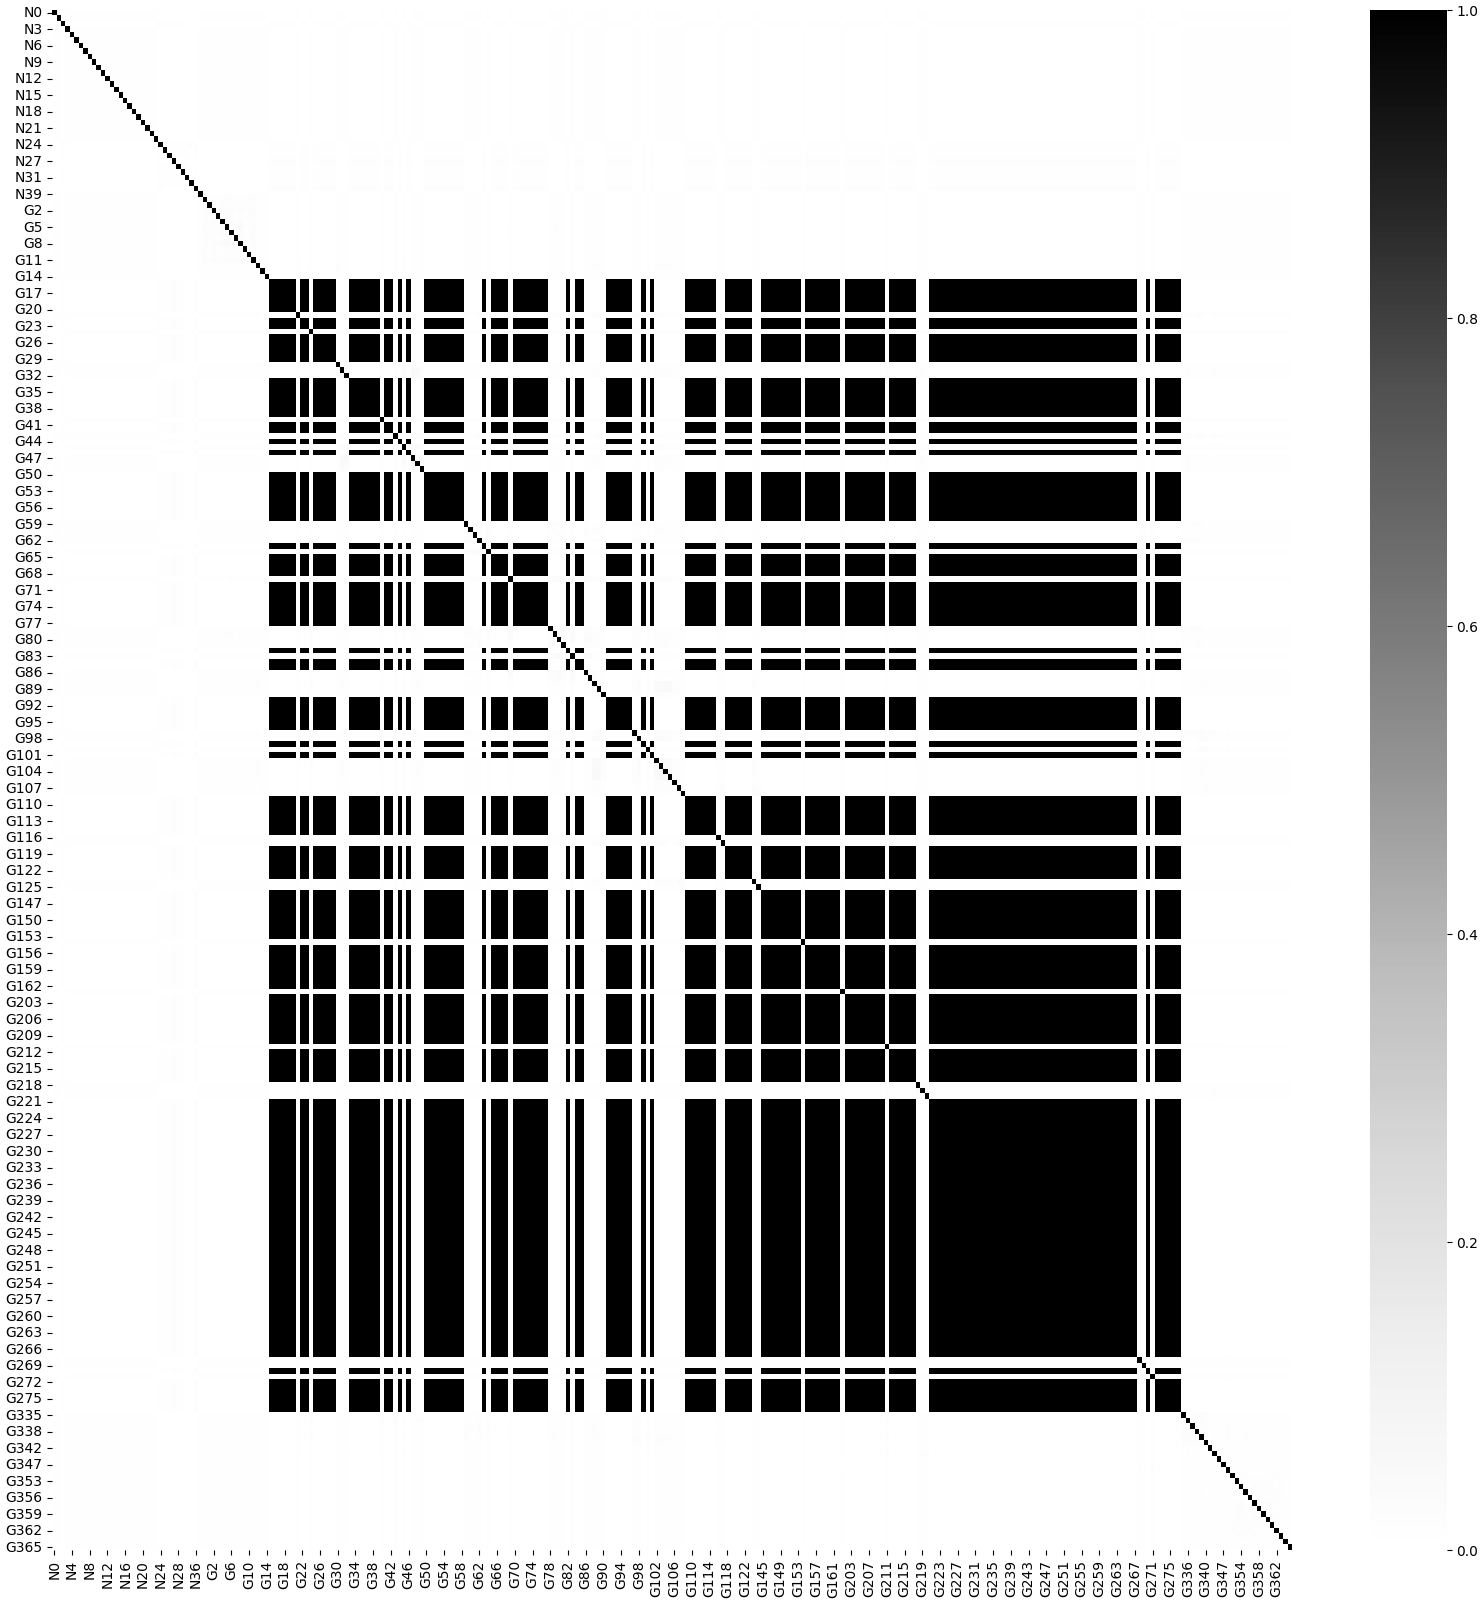

In [85]:
fig, ax = plt.subplots(figsize=(20,20))
sb.heatmap(knn_forb_norm_with_names, ax = ax, cmap = "Greys")

### Kernel

In [86]:
kernel_forb_norm = []

for g1 in all_dict["all_affs"]:
    forb_norm_with_g1 = []
    for g2 in all_dict["all_affs"]:
        diff = g1 - g2
        norm = np.linalg.norm(diff)
        forb_norm_with_g1.append(1/ (1+ norm))

    kernel_forb_norm.append(forb_norm_with_g1)

kernel_forb_norm = np.array(kernel_forb_norm)
kernel_forb_norm = min_max_scalar.fit_transform(kernel_forb_norm)
kernel_forb_norm_with_names = pd.DataFrame(kernel_forb_norm, index= all_dict["all_names"], columns= all_dict["all_names"])
kernel_forb_norm = pd.DataFrame(kernel_forb_norm)


<Axes: >

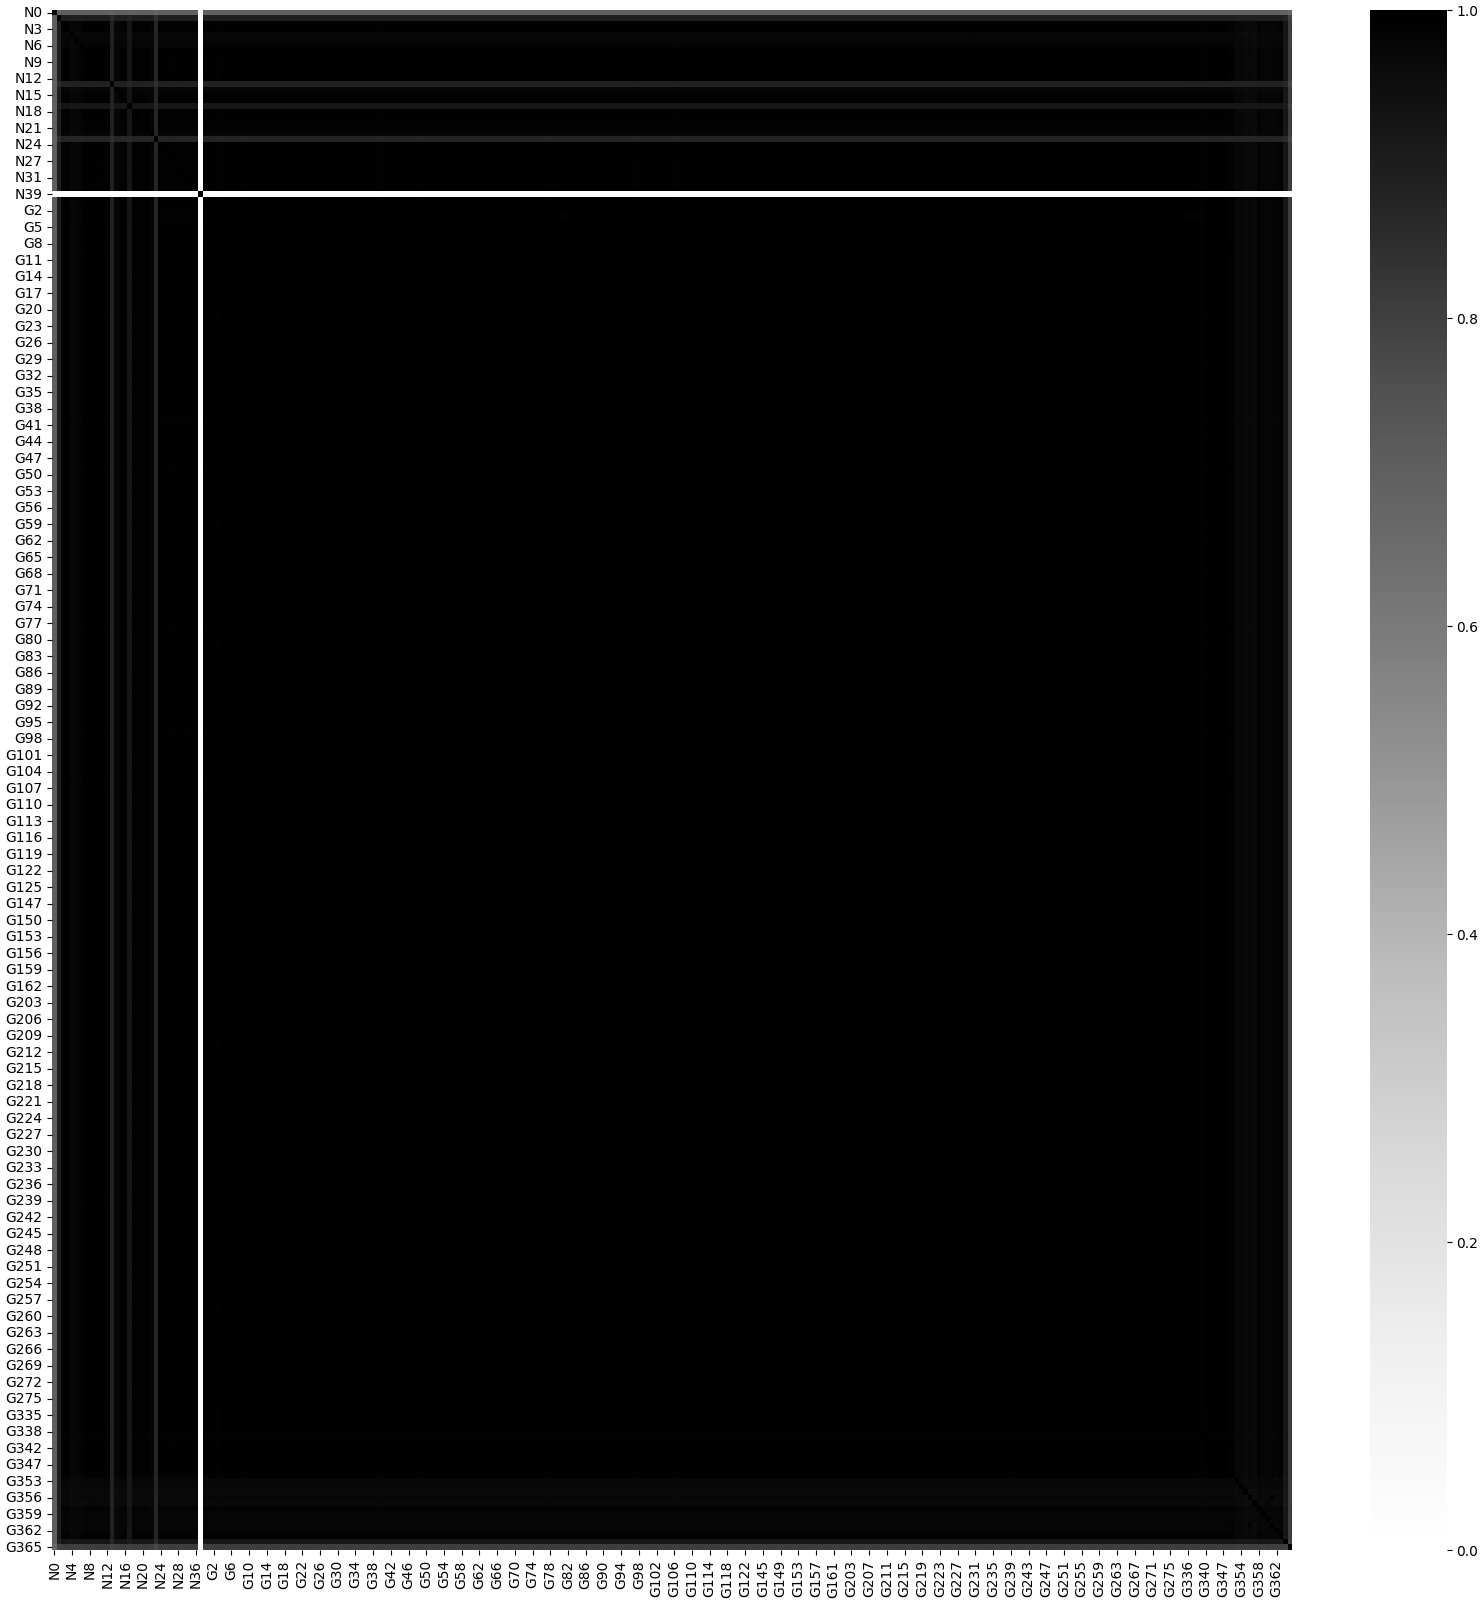

In [87]:
fig, ax = plt.subplots(figsize=(20,20))
sb.heatmap(kernel_forb_norm_with_names, ax = ax, cmap = "Greys")

## Correlation

### KNN

In [42]:
knn_corr = []

for g1 in all_dict["all_psns"]:
    corr_with_g1 = []
    g1 = g1.flatten()
    for g2 in all_dict["all_psns"]:
        g2 = g2.flatten()
        pearson = np.corrcoef(g1,g2)[0,1]
        corr_with_g1.append(pearson)
    knn_corr.append(corr_with_g1)

knn_corr = np.array(knn_corr)
knn_corr_with_names = pd.DataFrame(knn_corr, index= all_dict["all_names"], columns= all_dict["all_names"])
knn_corr = pd.DataFrame(knn_corr)

<Axes: >

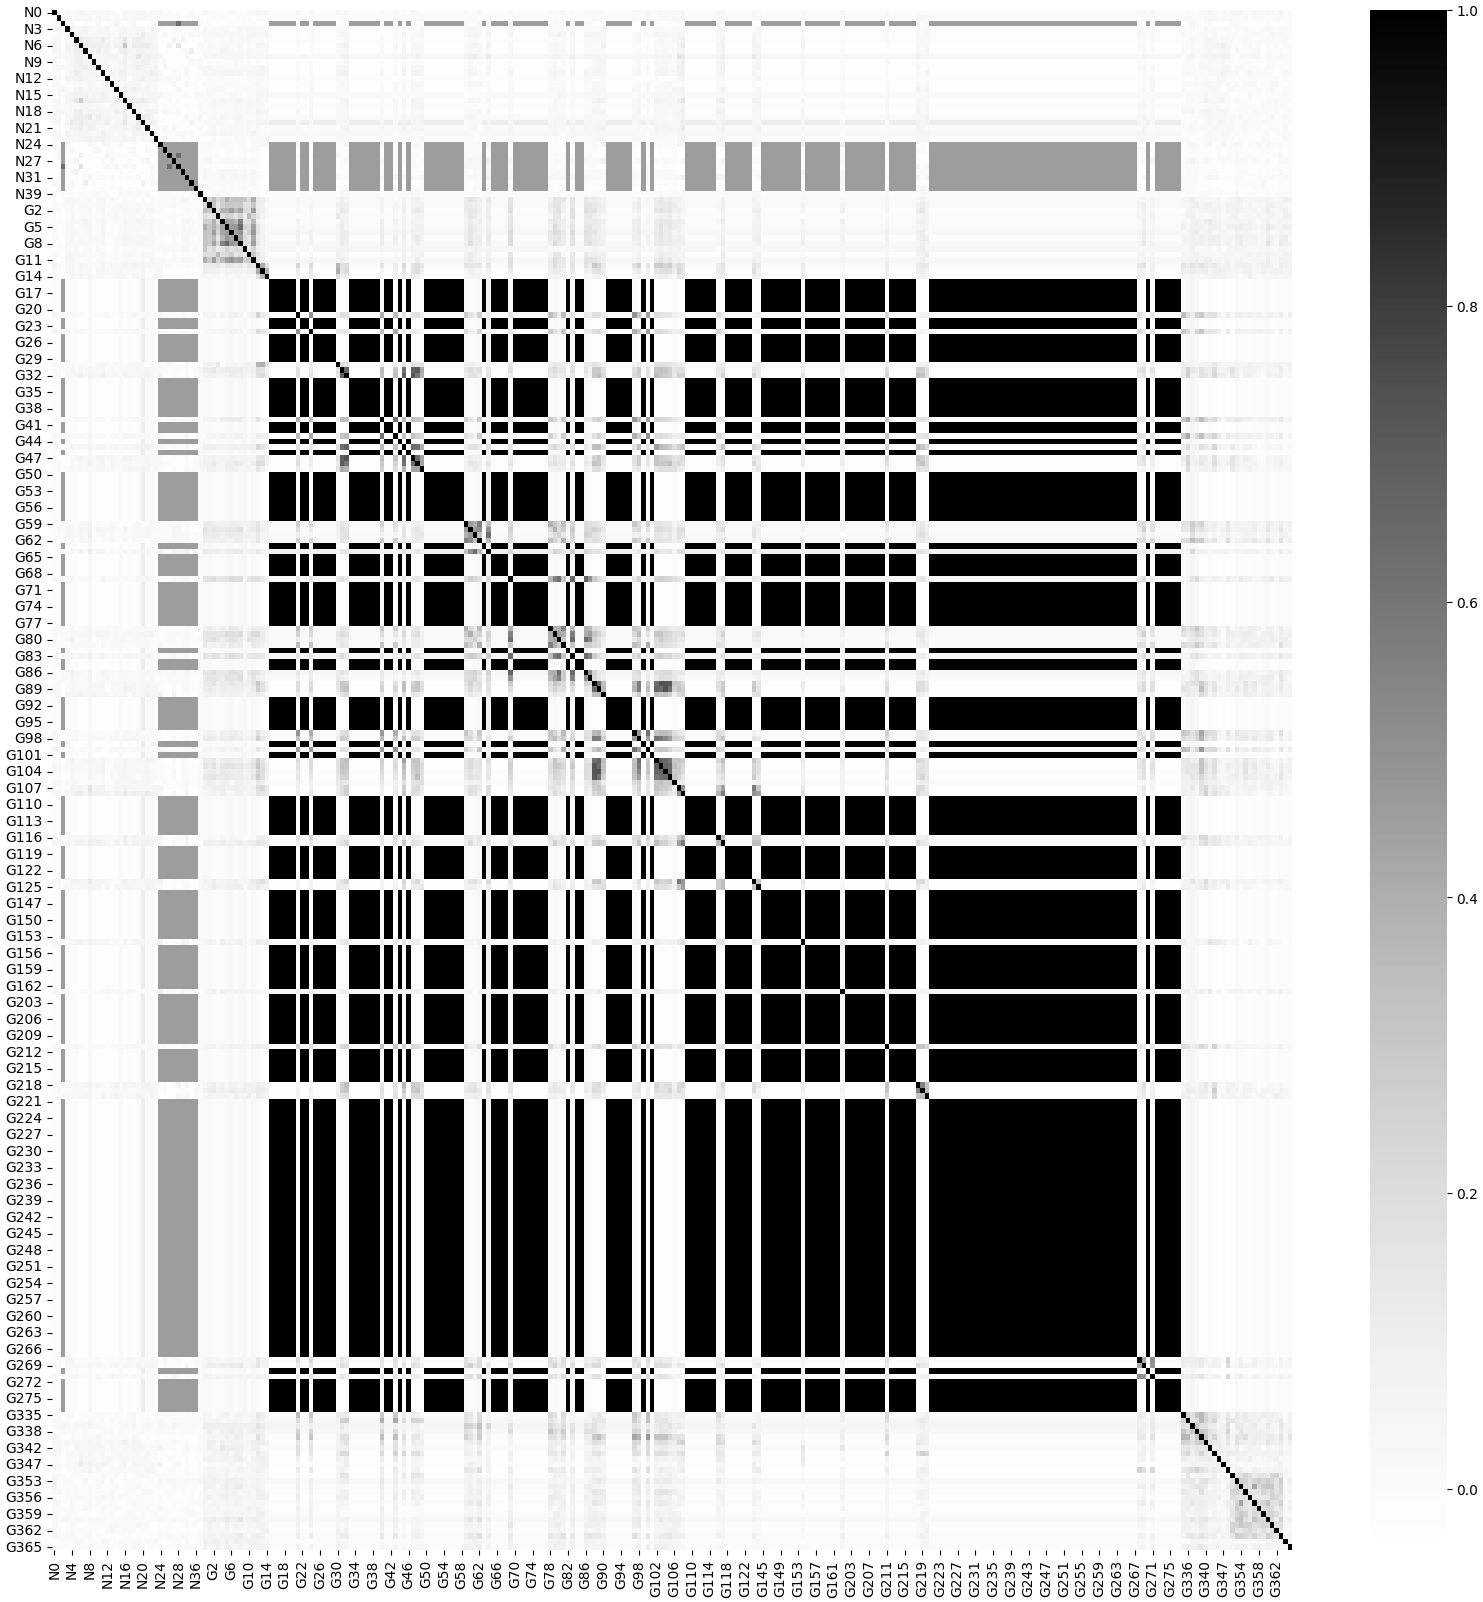

In [43]:
fig, ax = plt.subplots(figsize=(20,20))
sb.heatmap(knn_corr_with_names, ax = ax, cmap = "Greys")

### Kernel

In [89]:
kernel_corr = []

for g1 in all_dict["all_affs"]:
    corr_with_g1 = []
    g1 = g1.flatten()
    for g2 in all_dict["all_affs"]:
        g2 = g2.flatten()
        pearson = np.corrcoef(g1,g2)[0,1]
        corr_with_g1.append(pearson)
    kernel_corr.append(corr_with_g1)

kernel_corr = np.array(kernel_corr)
kernel_corr_with_names = pd.DataFrame(kernel_corr, index= all_dict["all_names"], columns= all_dict["all_names"])
kernel_corr = pd.DataFrame(kernel_corr)

<Axes: >

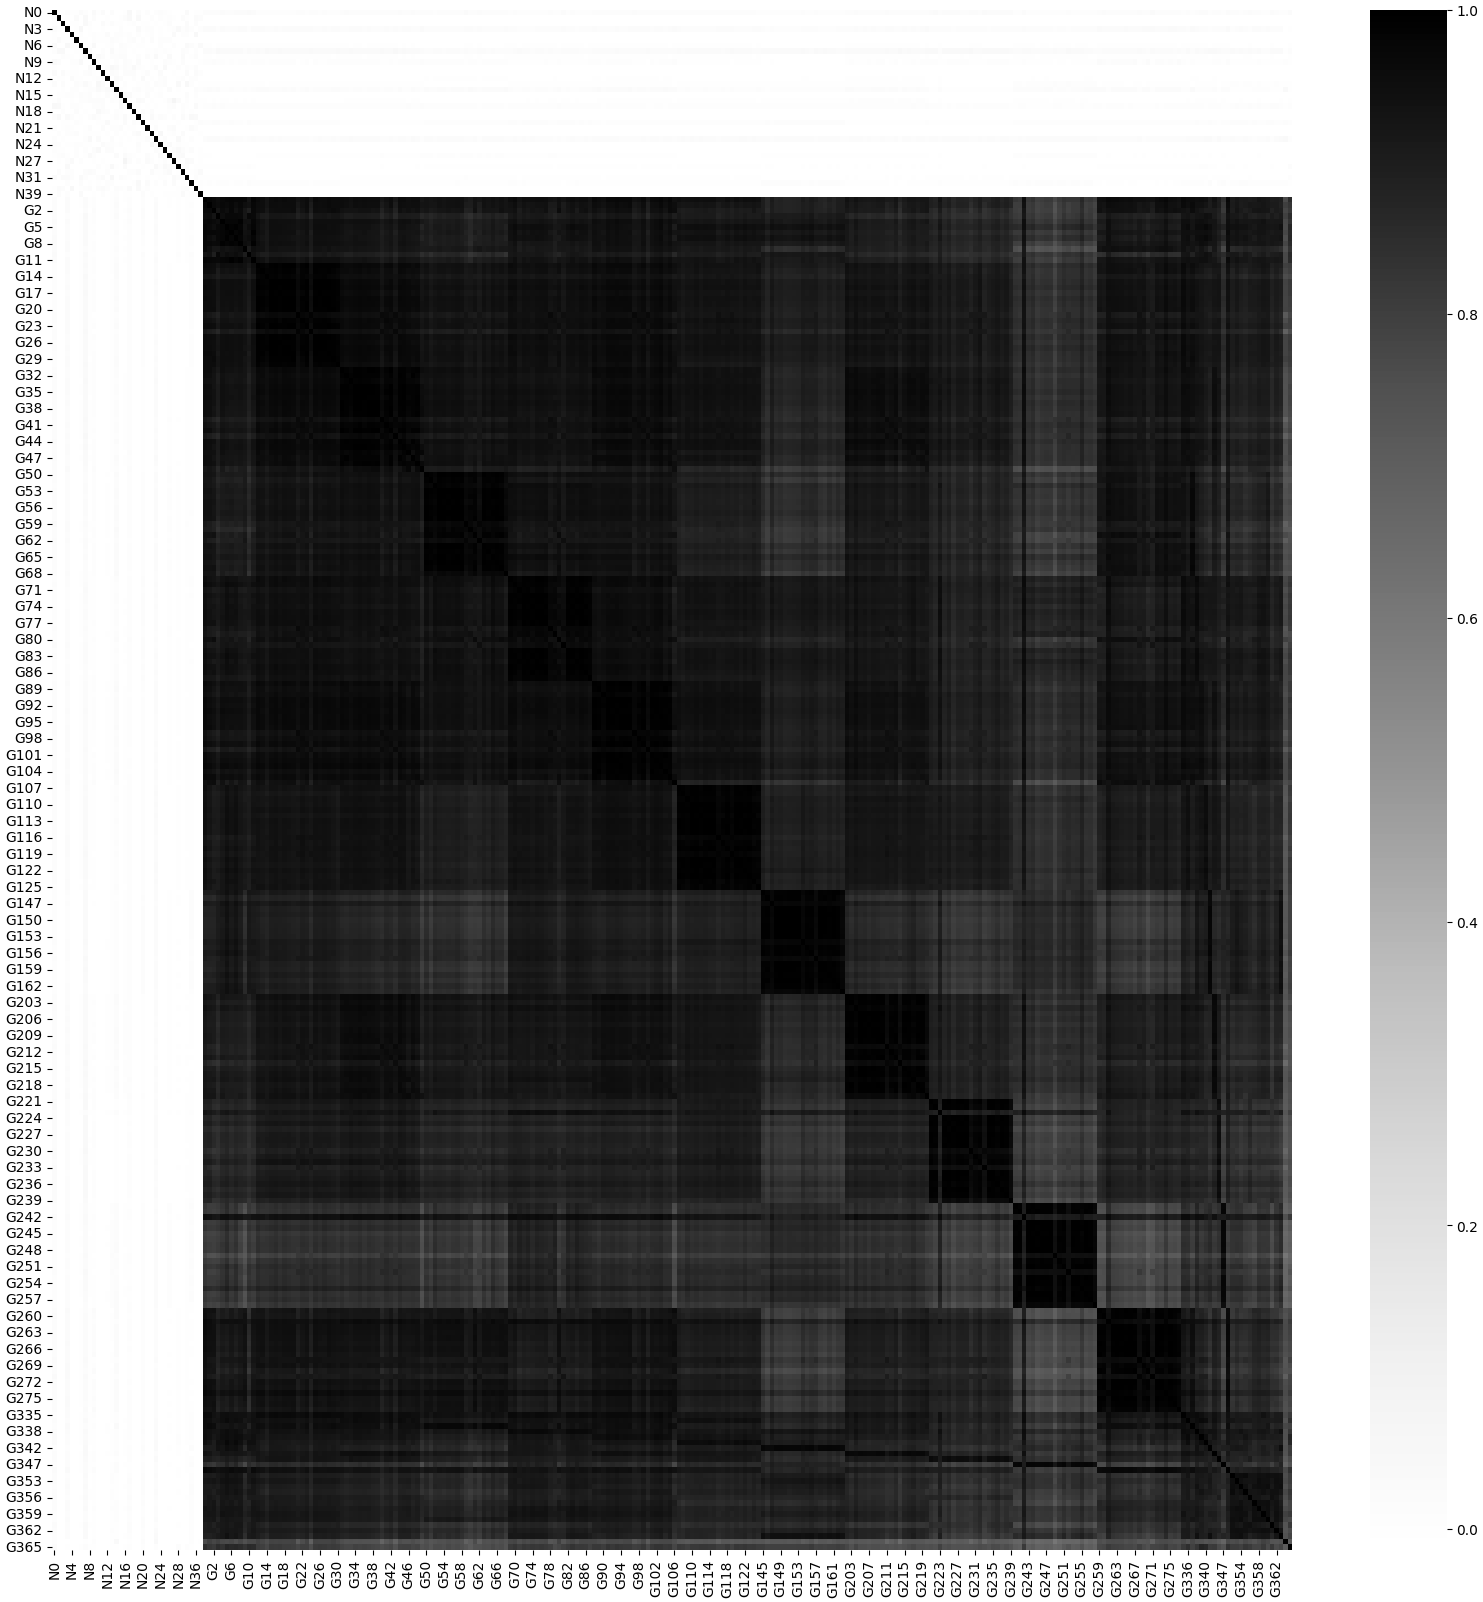

In [90]:
fig, ax = plt.subplots(figsize=(20,20))
sb.heatmap(kernel_corr_with_names, ax = ax, cmap = "Greys")

In [112]:
number_to_modality_new = {}
number_to_module_new = {}
all_anndata = noise_74.copy() | graphs_74.copy()

for i, id in enumerate(all_anndata.keys()):

    number_to_modality_new[i] = all_anndata[id].uns["modality"]
    number_to_module_new[i] = all_anndata[id].uns["module"]


df_row = pd.DataFrame(number_to_modality_new.values(), columns=["modality"]).join(pd.DataFrame(number_to_module_new.values(), columns=["module"]) )
df_column = pd.DataFrame(number_to_modality_new.values(), columns=["modality"]).join(pd.DataFrame(number_to_module_new.values(), columns=["module"]) )


row_colors_dict = {"module":{"None": "grey", "IFN": "blue", "C19": "red", "cycling": "orange", "ZNF": "green", "AP1": "purple", "Noise": "cyan" },
                  "modality":{"citeRNA":"skyblue", "bulkRNA": "darkorange" , "cytof": "wheat", "adt": "darkgray", "luminex": "orangered", "facs": "yellowgreen" }  }

row_ha = HeatmapAnnotation(Modality=anno_simple(df_row.modality,colors=row_colors_dict['modality'],rasterized=True),
                           Module=anno_simple(df_row.module,colors=row_colors_dict['module'],rasterized=True),
                           axis=0)

col_ha= HeatmapAnnotation(Modality=anno_simple(df_column.modality,colors=row_colors_dict['modality'],rasterized=True),
                          Module=anno_simple(df_column.module,colors=row_colors_dict['module'],rasterized=True),
                          axis=1)

TypeError: The length of `colors` is not consistent with the shape of the input data

Starting plotting..
Starting calculating row orders..
Reordering rows..
Starting calculating col orders..
Reordering cols..
Plotting matrix..


/Users/shakiba/Desktop/thesis.tmp/code/aggregated_patient_info/aggregated_patient_info/lib/python3.11/site-packages/PyComplexHeatmap/clustermap.py:803: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/Users/shakiba/Desktop/thesis.tmp/code/aggregated_patient_info/aggregated_patient_info/lib/python3.11/site-packages/PyComplexHeatmap/clustermap.py:803: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/Users/shakiba/Desktop/thesis.tmp/code/aggregated_patient_info/aggregated_patient_info/lib/python3.11/site-packages/PyComplexHeatmap/clustermap.py:803: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/Users/shakiba/Desktop/thesis.tmp/code/aggregated_patient_info/aggregated_patient_info/lib/python3.11/site-packages/PyComplexHeatmap/clustermap.py:803: UserWarning: Cluster

Starting plotting HeatmapAnnotations
Starting plotting HeatmapAnnotations
Plotting legends..


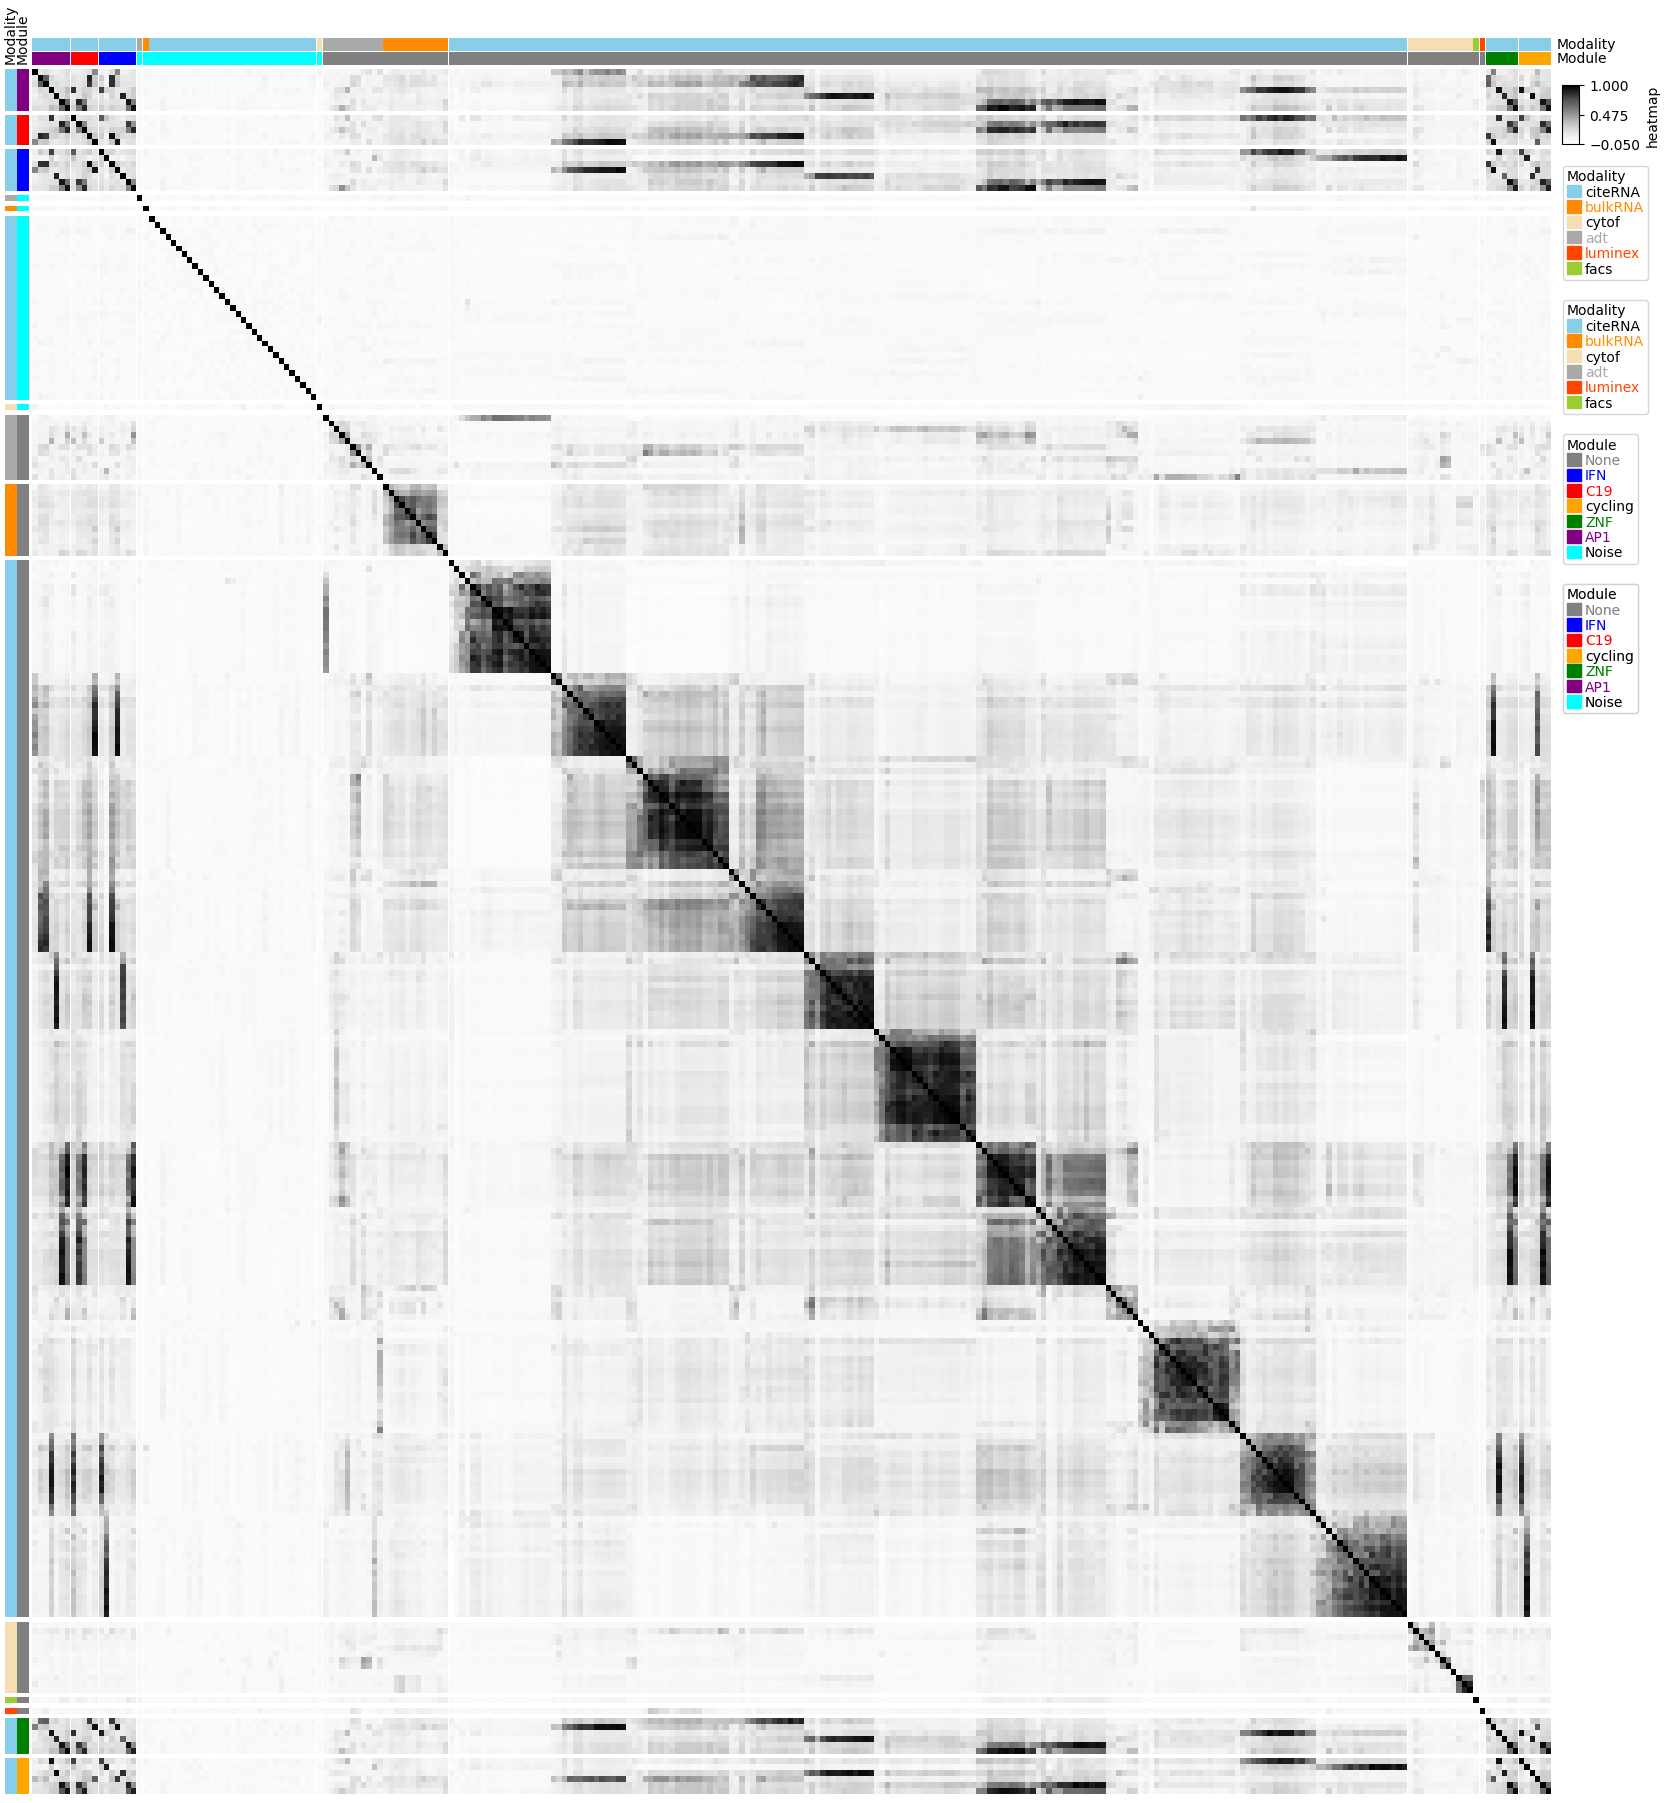

In [77]:

fig, ax = plt.subplots(figsize=(20,20))
forb_norm_with_noise_plt = ClusterMapPlotter(data=pd.DataFrame(kernel_corr_with_names.to_numpy(), index = list(number_to_module_new.keys()), columns =  list(number_to_module_new.keys())), top_annotation=col_ha, left_annotation=row_ha,
                     show_rownames=False,show_colnames=False,
                     row_dendrogram=False,col_dendrogram=False,
                     row_split=df_row.loc[:, ['module', 'modality']],
                     col_split=df_column.loc[:, ['module', 'modality']],
                     cmap='Greys',
                     rasterized=True,row_split_gap=1,legend=True,legend_anchor='ax_heatmap',legend_vpad=5)

In [113]:
#number_to_modality = {}
number_to_module = {}
#number_to_contribution = {}
number_to_cell_type = {}
number_to_process = {}


df = kernel_corr_with_names[list(citeRNA_kernel_74.keys())].transpose()[list(citeRNA_kernel_74.keys())]

for i, id in enumerate(citeRNA_kernel_74.keys()):

    #number_to_modality[i] = all_anndata[id].uns["modality"]
    number_to_module[id] = graphs_74[id].uns["module"]
    #number_to_contribution[i] = contribution[i]
    number_to_process[id] = graphs_74[id].uns["process"]
    number_to_cell_type[id] = graphs_74[id].uns["cell-type"]


df_column = pd.DataFrame(number_to_module.values(), columns=["module"], index=list(citeRNA_kernel_74.keys())).join(pd.DataFrame(number_to_process.values(), columns=["process"], index=list(citeRNA_kernel_74.keys()))).join(pd.DataFrame(number_to_cell_type.values(), columns=["cell_type"], index=list(citeRNA_kernel_74.keys())))



col_colors_dict = {"process":{"None": "white", "IFN": "blue", "C19": "red", "cycling": "orange", "ZNF": "green", "AP1": "purple", "noise": "cyan" },
                  #"module":{m: m for m in set(modules) if not m == "None" and not m == "grey60"} | { "None": "white", "grey60":"lightgrey"},
                  "cell_type":{"B":"darkblue", "Basophil": "darkred" , "CD4": "darkorange", "CD8": "brown", "DC": "darkgreen", "DN": "navy", "DP":"black", 'GDT':"lime", 'HSC': "olive", 'MAIT': "fuchsia", 'NK': "maroon", 'PB':"coral", 'bulk':"aqua", 'cMono':"teal", 'ncMono':"plum" } }


col_ha= HeatmapAnnotation(
                          Process=anno_simple(df_column.process,colors=col_colors_dict['process'],rasterized=True),
                          #Module=anno_simple(df_column.module,colors=col_colors_dict['module'],rasterized=True),
                          CellType=anno_simple(df_column.cell_type,colors=col_colors_dict['cell_type'],rasterized=True),
                          axis=1)

row_ha= HeatmapAnnotation(Process=anno_simple(df_column.process,colors=col_colors_dict['process'],rasterized=True),
                          #Module=anno_simple(df_column.module,colors=col_colors_dict['module'],rasterized=True),
                          CellType=anno_simple(df_column.cell_type,colors=col_colors_dict['cell_type'],rasterized=True),
                          axis=0)

TypeError: The length of `colors` is not consistent with the shape of the input data

Starting plotting..
Starting calculating row orders..
Reordering rows..
Starting calculating col orders..
Reordering cols..
Plotting matrix..


/Users/shakiba/Desktop/thesis.tmp/code/aggregated_patient_info/aggregated_patient_info/lib/python3.11/site-packages/PyComplexHeatmap/clustermap.py:803: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/Users/shakiba/Desktop/thesis.tmp/code/aggregated_patient_info/aggregated_patient_info/lib/python3.11/site-packages/PyComplexHeatmap/clustermap.py:803: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/Users/shakiba/Desktop/thesis.tmp/code/aggregated_patient_info/aggregated_patient_info/lib/python3.11/site-packages/PyComplexHeatmap/clustermap.py:803: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/Users/shakiba/Desktop/thesis.tmp/code/aggregated_patient_info/aggregated_patient_info/lib/python3.11/site-packages/PyComplexHeatmap/clustermap.py:803: UserWarning: Cluster

Starting plotting HeatmapAnnotations
Starting plotting HeatmapAnnotations
Plotting legends..


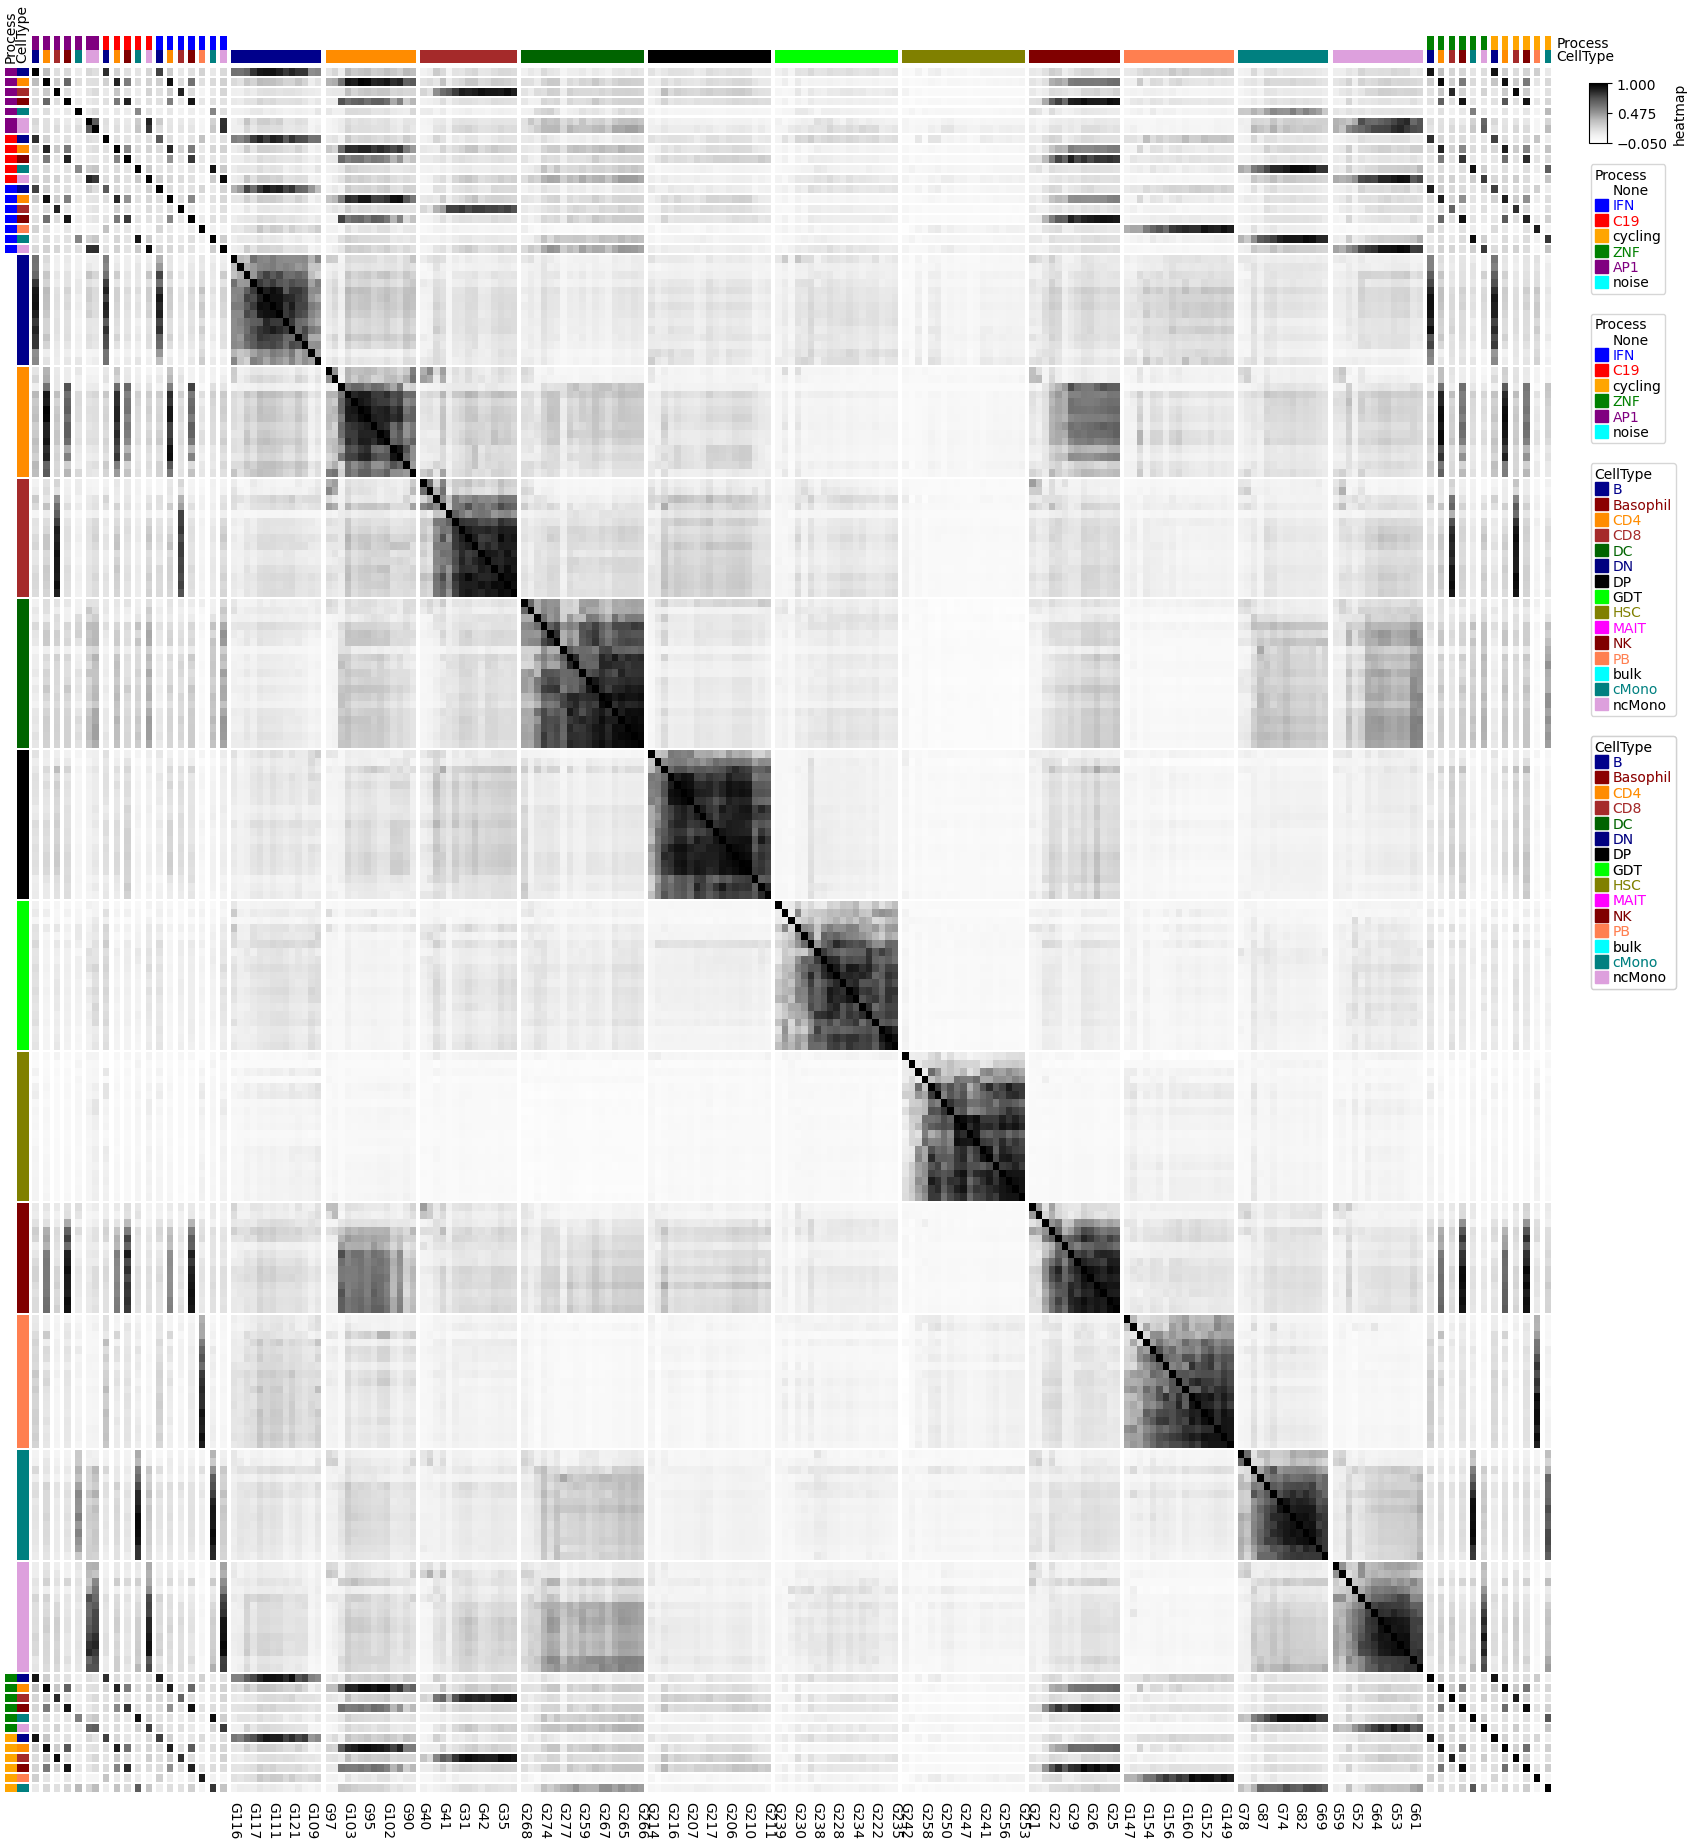

In [19]:
fig, ax = plt.subplots(figsize=(20,20))
ami_kernel_plt = ClusterMapPlotter(data=df, top_annotation=col_ha, left_annotation = row_ha,
                     show_rownames=False,show_colnames=True,
                     row_dendrogram=False,col_dendrogram=False,
                     col_split=df_column.loc[:, ["process", "cell_type",  ]],
                     row_split=df_column.loc[:, ["process", "cell_type",  ]],
                     cmap='Greys',
                     rasterized=True,col_split_gap=1.2,legend=True,legend_anchor='ax_heatmap',legend_vpad=5,legend_hpad= 8 )

# Negative Control

## Score Decline

In [46]:
snf_none_noise = compute.snf(list(kernel_PSNs.values()), K=6, t = 60)
tm_none_noise = make_transition_matrix(snf_none_noise)
rw_non_noise = random_walker_objective(tm_none_noise)[2]

snf_noise = compute.snf(all_dict["all_affs"], K=6, t = 60)
tm_noise = make_transition_matrix(snf_noise)
rw_noise = random_walker_objective(tm_noise)[2]

print(rw_non_noise > rw_noise )

True


In [47]:
first, second = compute.get_n_clusters(snf_none_noise)
labels_none_noise = sc_labels_kernel = cluster.spectral_clustering(snf_none_noise, n_clusters=first, n_init = 40)
sil_none_noise = skl.metrics.silhouette_score(snf_none_noise, labels_none_noise)

first, second = compute.get_n_clusters(snf_noise)
labels_noise = sc_labels_kernel = cluster.spectral_clustering(snf_noise, n_clusters=first, n_init = 40)
sil_noise = skl.metrics.silhouette_score(snf_noise, labels_noise)

print(sil_none_noise > sil_noise )

/Users/shakiba/Desktop/thesis.tmp/code/aggregated_patient_info/aggregated_patient_info/lib/python3.11/site-packages/sklearn/manifold/_spectral_embedding.py:247: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)


True


/Users/shakiba/Desktop/thesis.tmp/code/aggregated_patient_info/aggregated_patient_info/lib/python3.11/site-packages/sklearn/manifold/_spectral_embedding.py:247: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)


In [48]:
ami_none_noise = ami(list(labels["ground_truth_d"].values()), labels_none_noise)
ami_noise = ami(list(labels["ground_truth_d"].values()), labels_noise)

print(ami_none_noise > ami_noise )

True


In [49]:
db_none_noise = skl.metrics.davies_bouldin_score(snf_none_noise, labels_none_noise)
db_noise = skl.metrics.davies_bouldin_score(snf_noise, labels_noise)

print(db_none_noise < db_noise ) #The smaller the  better

True


## AMI with SNF vs. AMI with Ground-Truth

<Axes: >

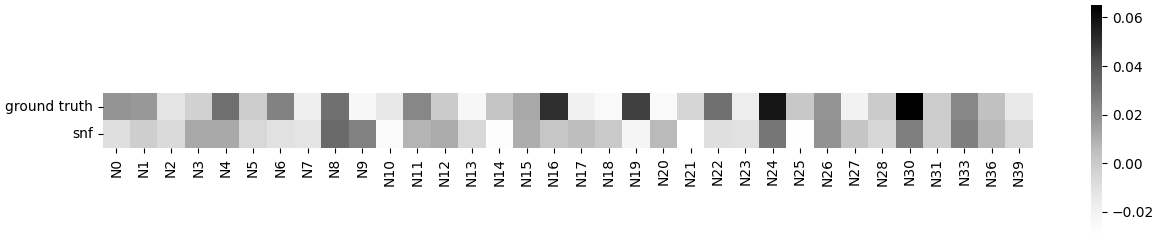

In [50]:
noise_labels = {"ground_truth": ground_truth, "snf": fused_snf_labels }
for name in list(noise_74.keys()):
    noise_labels[name] = labels_kernel_sc[name]


ami_noise = []
for k1 in list(noise_labels.keys())[:2]:
    g1 = noise_labels[k1]
    ami_with_g1 = []
    for k2 in list(noise_labels.keys())[2:]:
        g2 = noise_labels[k2]
        ami_score = ami(g1,g2)
        ami_with_g1.append(ami_score)
    
    ami_noise.append(ami_with_g1)

fig, ax = plt.subplots(figsize=(15,15))
sb.heatmap(pd.DataFrame(ami_noise, index = ["ground truth", "snf"], columns = list(noise_74.keys())), ax = ax, cmap = "Greys", square=True, cbar_kws={"shrink": 0.2})

<Axes: >

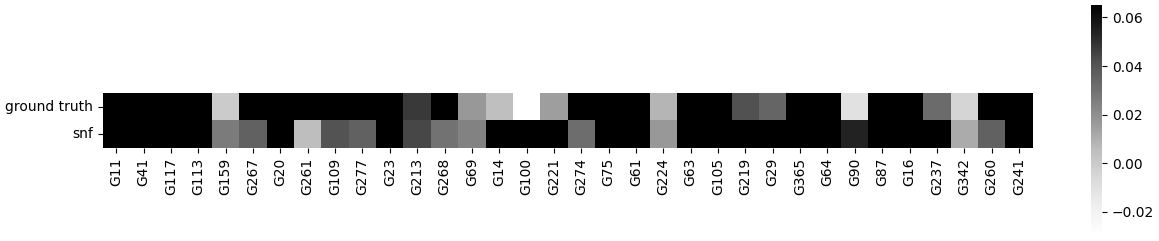

In [51]:
non_noise_labels = {"ground_truth": ground_truth, "snf": fused_snf_labels }
non_noise_random = np.random.choice(list(graphs_74.keys()), len(noise_74.keys()), replace=False)
for name in non_noise_random:
    non_noise_labels[name] = labels_kernel_sc[name]

ami_non_noise = []
for k1 in list(non_noise_labels.keys())[:2]:
    g1 = non_noise_labels[k1]
    ami_with_g1 = []
    for k2 in list(non_noise_labels.keys())[2:]:
        g2 = non_noise_labels[k2]
        ami_score = ami(g1,g2)
        ami_with_g1.append(ami_score)
    
    ami_non_noise.append(ami_with_g1)

fig, ax = plt.subplots(figsize=(15,15))
sb.heatmap(pd.DataFrame(ami_non_noise, index = ["ground truth", "snf"], columns = non_noise_random), ax = ax, cmap = "Greys", square=True, cbar_kws={"shrink": 0.2}, vmin=pd.DataFrame(ami_noise).min().min(), vmax=pd.DataFrame(ami_noise).max().max())

# Positive Control

## Kernel-PSN contribution to Ground Truth measured via AMI, Similirty measured via AMI, Labels extracted via Spectral Clustering

In [ ]:
g1 = ground_truth
contributions = []
for g2 in list(kernel_labels.values())[2:]: 
        ami_score = ami(g1,g2)
        contributions.append(ami_score)

contributions = np.array(contributions)


similarities = []
for g1 in list(kernel_labels.values())[2:]: 
    ami_with_g1 = []
    for g2 in list(kernel_labels.values())[2:]: 
            ami_score = ami(g1,g2)
            ami_with_g1.append(ami_score)
    similarities.append(ami_with_g1)
similarities = pd.DataFrame(similarities, index= list(kernel_labels.keys())[2:], columns= list(kernel_labels.keys())[2:])

contribution_differences = []
for i, c1 in enumerate(contributions):
    cont_diff = []
    for j, c2 in enumerate(contributions):
       cont_diff.append(abs(c1 - c2))
    contribution_differences.append(cont_diff)
contribution_differences = pd.DataFrame(contribution_differences, columns = list(graphs_74.keys()), index = list(graphs_74.keys()))

tolerance = np.percentile(contribution_differences, 35)

pc1 = []
for i in similarities.index:
    pc = []
    for j in similarities.columns:
        s = similarities.loc[i,j]
        c = contribution_differences.loc[i,j]
        if s >= 0.6:
            if c <= tolerance:
                pc.append(1)
            else:
                pc.append(0)
        else:
            pc.append(0.5)
    pc1.append(pc)

<Axes: >

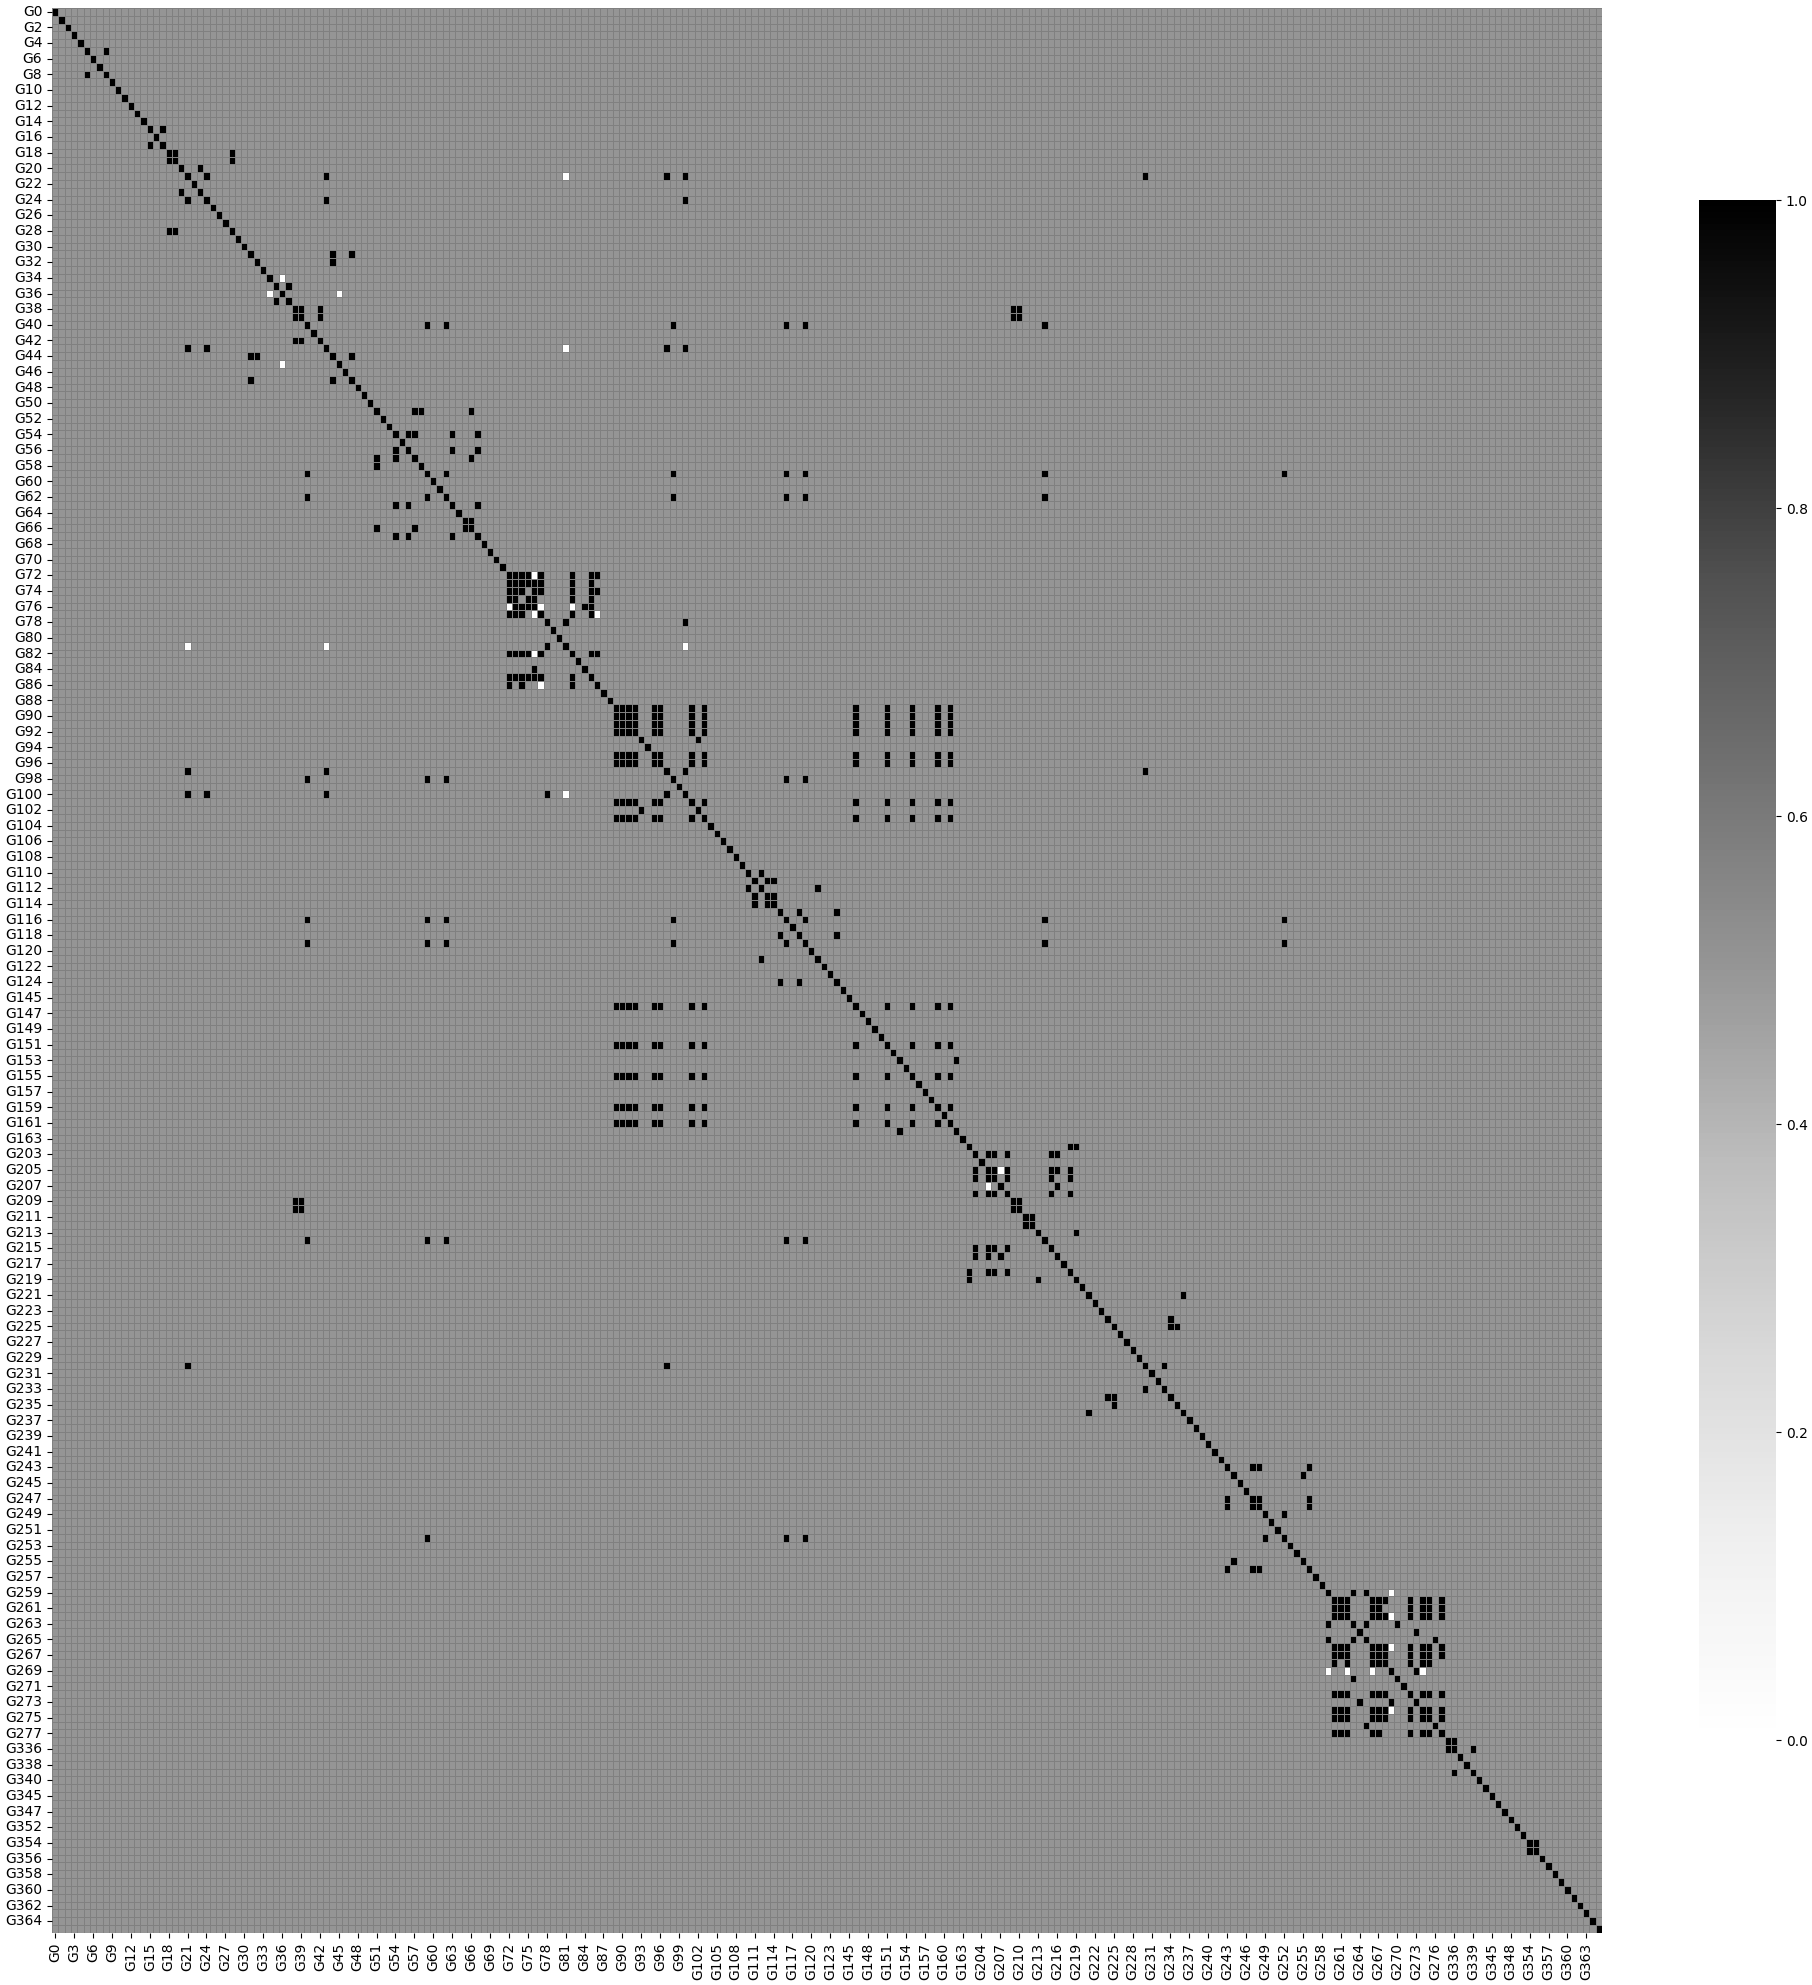

In [ ]:
fig, ax = plt.subplots(figsize=(25,25))
sb.heatmap(pd.DataFrame(pc1, index = list(graphs_74.keys()), columns = list(graphs_74.keys())), ax = ax, cmap = "Greys", robust = False, linewidth=.5, linecolor = "grey", cbar_kws={"shrink": 0.8}, cbar = True)

## Kernel-PSN contributin to SNF-Fusion measured via AMI, Similarity measured via AMI, Labels extracted via Spectral Clustering

In [ ]:
g1 = fused_snf_labels
contributions = []
for g2 in list(kernel_labels.values())[2:]: 
        ami_score = ami(g1,g2)
        contributions.append(ami_score)

contributions = np.array(contributions)

similarities = []
for g1 in list(kernel_labels.values())[2:]: 
    ami_with_g1 = []
    for g2 in list(kernel_labels.values())[2:]: 
            ami_score = ami(g1,g2)
            ami_with_g1.append(ami_score)
    similarities.append(ami_with_g1)
similarities = pd.DataFrame(similarities, index= list(kernel_labels.keys())[2:], columns= list(kernel_labels.keys())[2:])

contribution_differences = []
for i, c1 in enumerate(contributions):
    cont_diff = []
    for j, c2 in enumerate(contributions):
       cont_diff.append(abs(c1 - c2))
    contribution_differences.append(cont_diff)
contribution_differences = pd.DataFrame(contribution_differences, columns = list(graphs_74.keys()), index = list(graphs_74.keys()))

tolerance = np.percentile(contribution_differences, 35)

pc2 = []
for i in similarities.index:
    pc = []
    for j in similarities.columns:
        s = similarities.loc[i,j]
        c = contribution_differences.loc[i,j]
        if s >= 0.6:
            if c <= tolerance:
                pc.append(1)
            else:
                pc.append(0)
        else:
            pc.append(0.5)
    pc2.append(pc)

<Axes: >

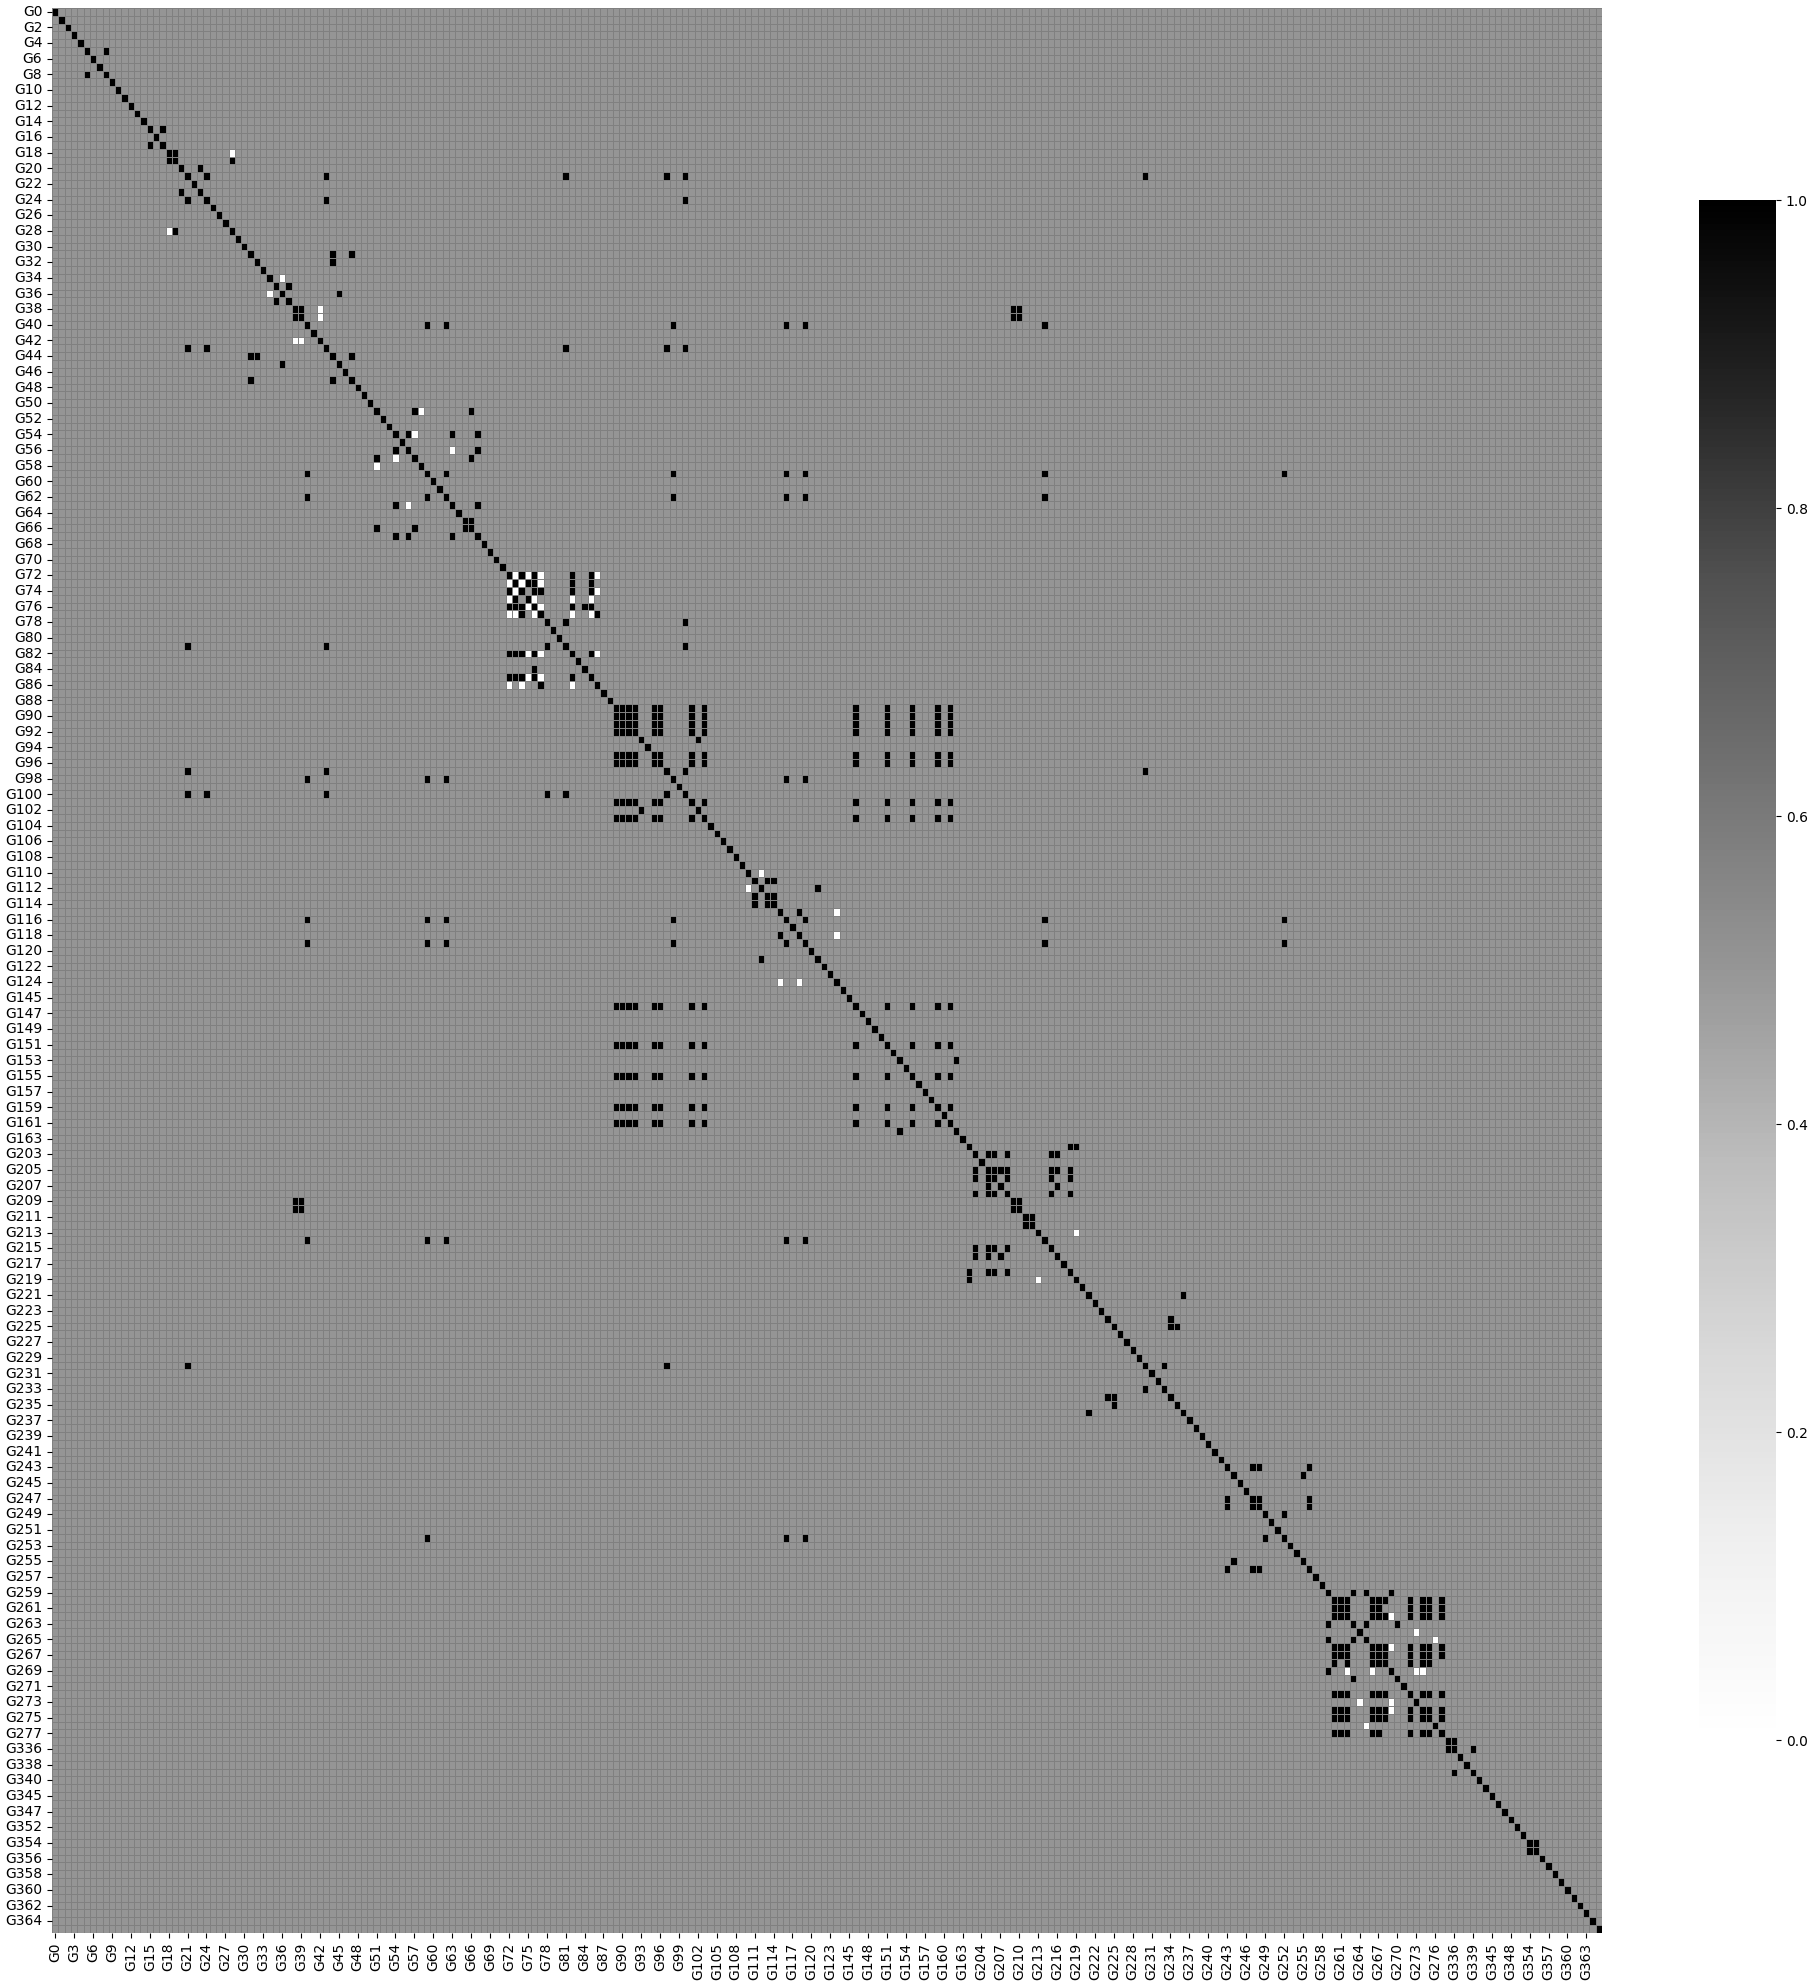

In [ ]:
fig, ax = plt.subplots(figsize=(25,25))
sb.heatmap(pd.DataFrame(pc2, index = list(graphs_74.keys()), columns = list(graphs_74.keys())), ax = ax, cmap = "Greys", robust = False, linewidth=.5, linecolor = "grey", cbar_kws={"shrink": 0.8}, cbar = True)

## KNN-PSN contribution to Ground Truth measured via AMI, Similarity measured via AMI, Labels extracted via Leiden Clustering

In [56]:
g1 = ground_truth
contributions = []
for g2 in list(knn_labels.values())[2:]: 
        ami_score = ami(g1,g2)
        contributions.append(ami_score)

contributions = np.array(contributions)

similarities = []
for g1 in list(knn_labels.values())[2:]: 
    ami_with_g1 = []
    for g2 in list(knn_labels.values())[2:]: 
            ami_score = ami(g1,g2)
            ami_with_g1.append(ami_score)
    similarities.append(ami_with_g1)
similarities = pd.DataFrame(similarities, index= list(knn_labels.keys())[2:], columns= list(knn_labels.keys())[2:])

contribution_differences = []
for i, c1 in enumerate(contributions):
    cont_diff = []
    for j, c2 in enumerate(contributions):
       cont_diff.append(abs(c1 - c2))
    contribution_differences.append(cont_diff)
contribution_differences = pd.DataFrame(contribution_differences, columns = list(graphs_74.keys()), index = list(graphs_74.keys()))

tolerance = np.percentile(contribution_differences, 35)

pc3 = []
for i in similarities.index:
    pc = []
    for j in similarities.columns:
        s = similarities.loc[i,j]
        c = contribution_differences.loc[i,j]
        if s >= 0.6:
            if c <= tolerance:
                pc.append(1)
            else:
                pc.append(0)
        else:
            pc.append(0.5)
    pc3.append(pc)

<Axes: >

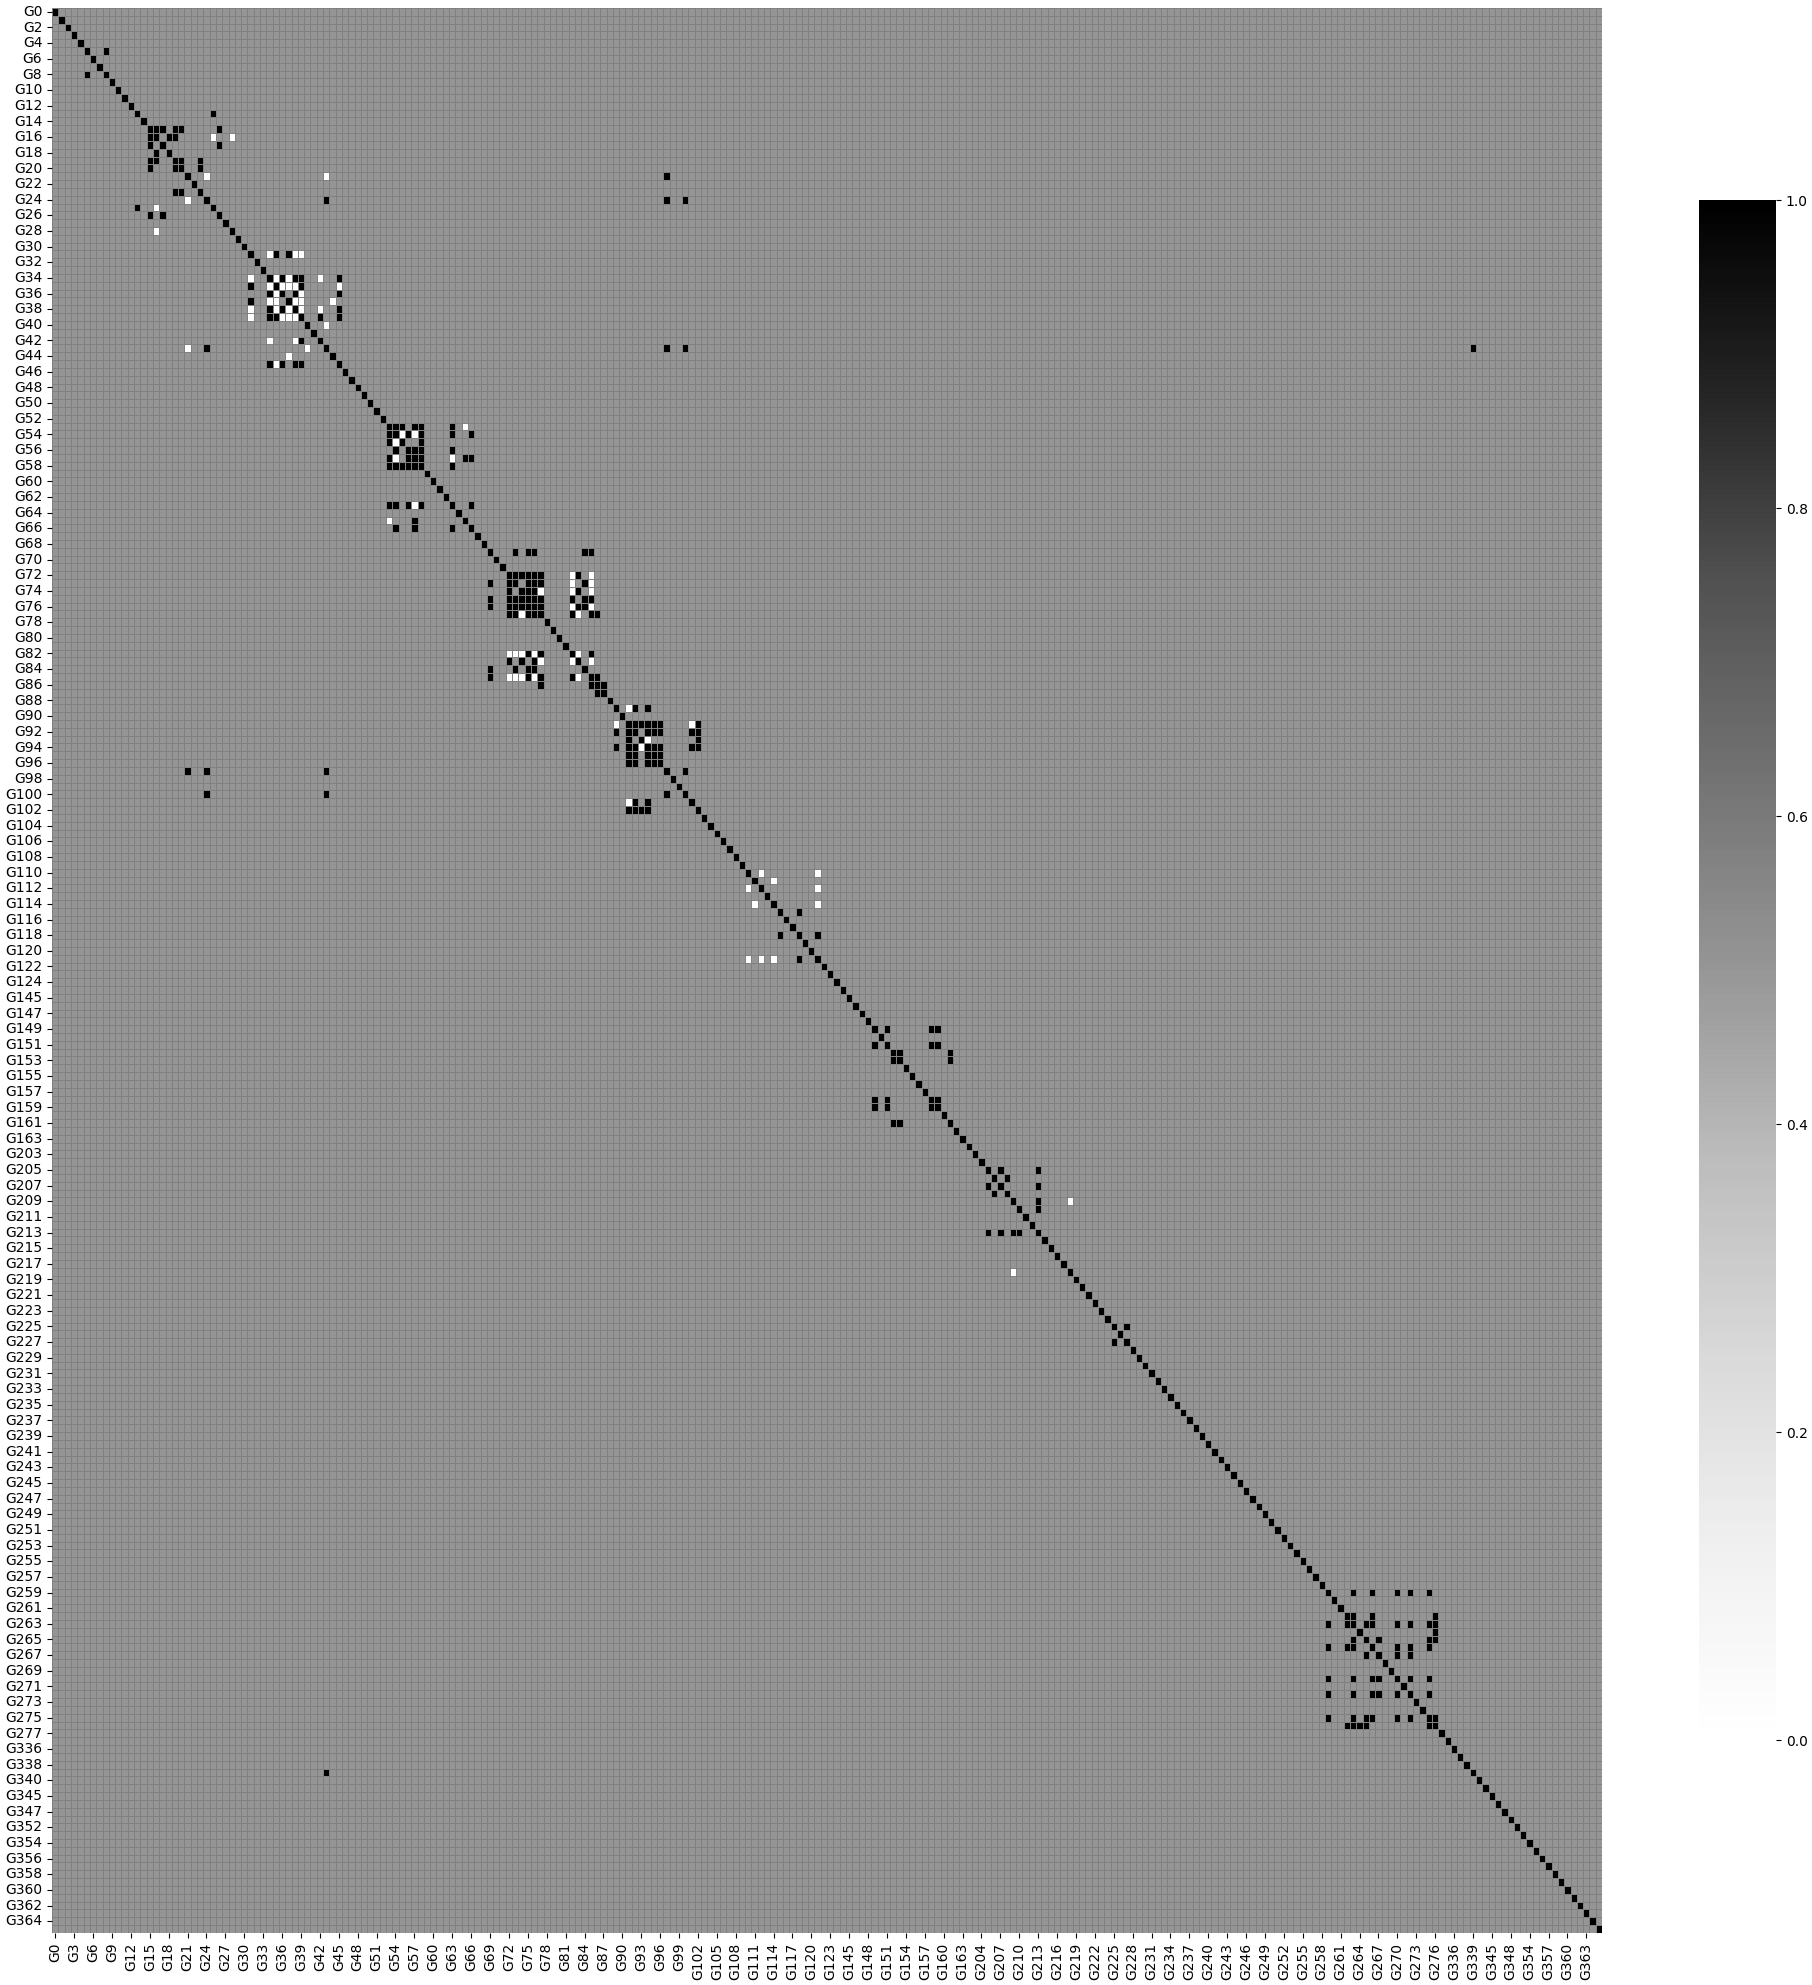

In [57]:
fig, ax = plt.subplots(figsize=(25,25))
sb.heatmap(pd.DataFrame(pc3, index = list(graphs_74.keys()), columns = list(graphs_74.keys())), ax = ax, cmap = "Greys", robust = False, linewidth=.5, linecolor = "grey", cbar_kws={"shrink": 0.8}, cbar = True)

## KNN-PSN contribution to WA-Fusion measured via AMI, Similarity measured via AMI, Labels extracted via Leiden Clustering

In [58]:
g1 = fused_wa_labels
contributions = []
for g2 in list(knn_labels.values())[2:]: 
        ami_score = ami(g1,g2)
        contributions.append(ami_score)

contributions = np.array(contributions)

similarities = []
for g1 in list(knn_labels.values())[2:]: 
    ami_with_g1 = []
    for g2 in list(knn_labels.values())[2:]: 
            ami_score = ami(g1,g2)
            ami_with_g1.append(ami_score)
    similarities.append(ami_with_g1)
similarities = pd.DataFrame(similarities, index= list(knn_labels.keys())[2:], columns= list(knn_labels.keys())[2:])

contribution_differences = []
for i, c1 in enumerate(contributions):
    cont_diff = []
    for j, c2 in enumerate(contributions):
       cont_diff.append(abs(c1 - c2))
    contribution_differences.append(cont_diff)
contribution_differences = pd.DataFrame(contribution_differences, columns = list(graphs_74.keys()), index = list(graphs_74.keys()))

tolerance = np.percentile(contribution_differences, 35)

pc4 = []
for i in similarities.index:
    pc = []
    for j in similarities.columns:
        s = similarities.loc[i,j]
        c = contribution_differences.loc[i,j]
        if s >= 0.6:
            if c <= tolerance:
                pc.append(1)
            else:
                pc.append(0)
        else:
            pc.append(0.5)
    pc4.append(pc)

<Axes: >

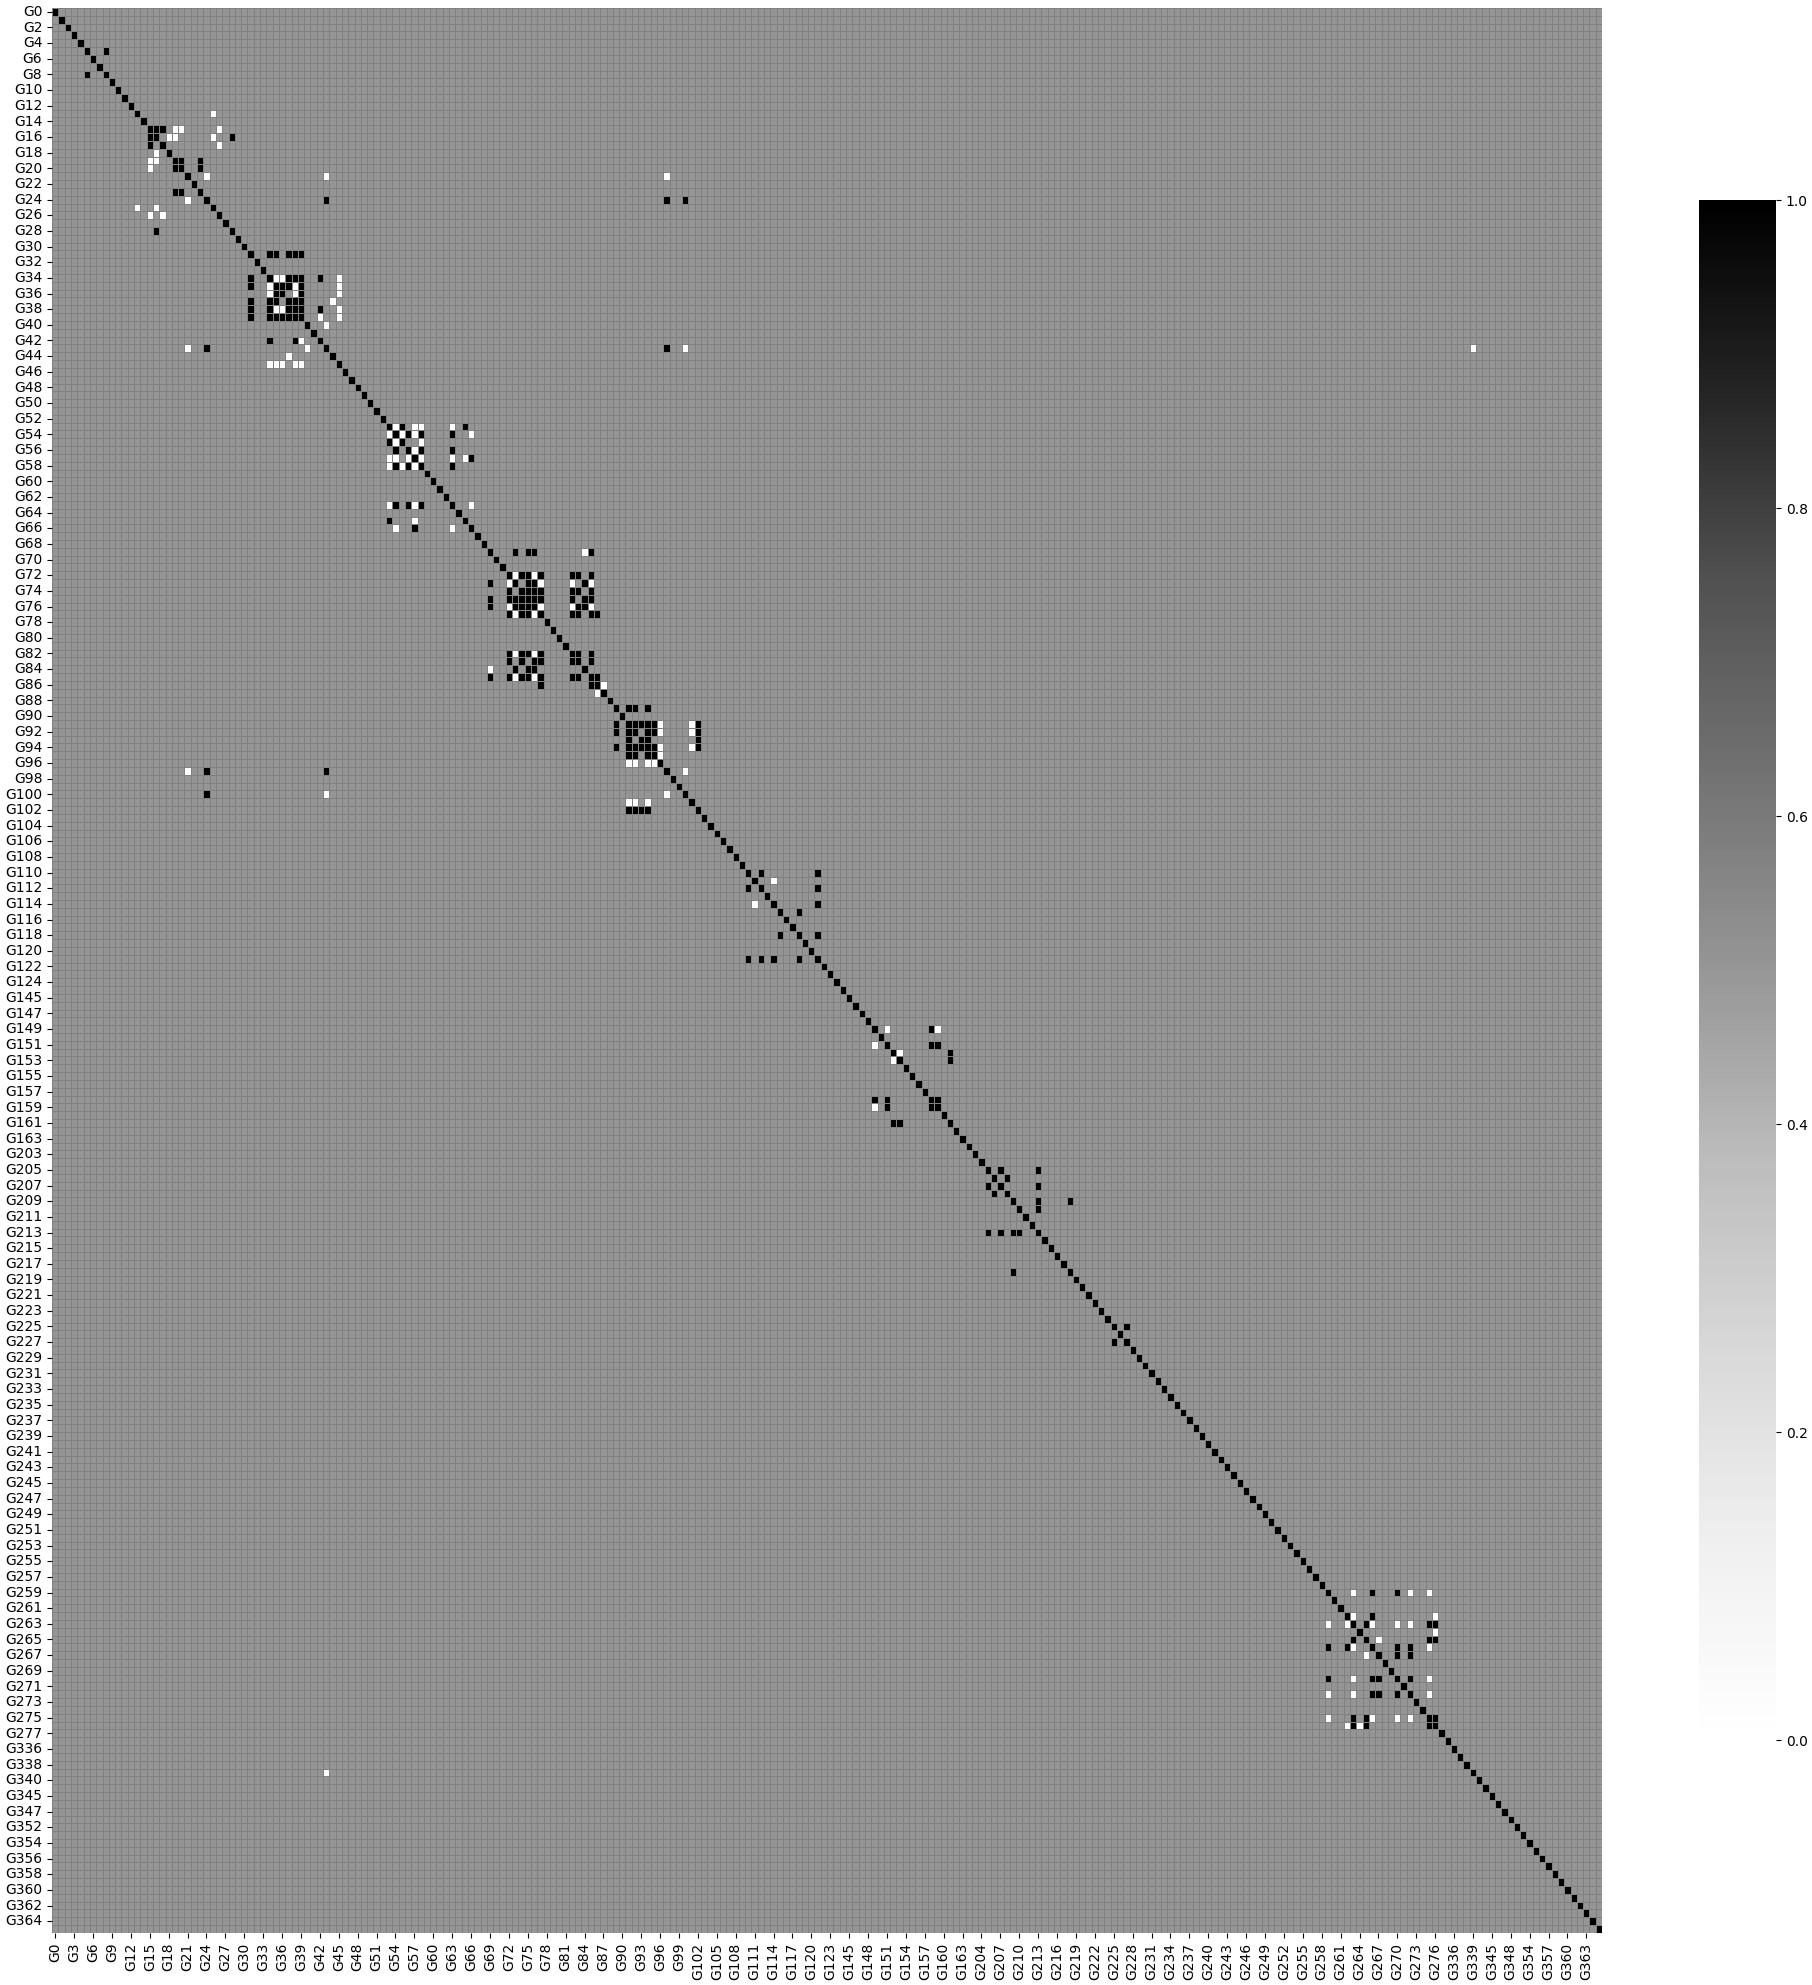

In [59]:
fig, ax = plt.subplots(figsize=(25,25))
sb.heatmap(pd.DataFrame(pc4, index = list(graphs_74.keys()), columns = list(graphs_74.keys())), ax = ax, cmap = "Greys", robust = False, linewidth=.5, linecolor = "grey", cbar_kws={"shrink": 0.8}, cbar = True)

## Silhoute of fused > Silhoute of unimodal
## PR of fused > PR of unimodal

In [90]:
silhouette_dict  = {"correct":0, "incorrect":0 }
pr_dict  = {"correct":0, "incorrect":0 }


for id, psn in kernel_PSNs.items():

    tm = make_transition_matrix(psn)
    score = random_walker_objective(tm)[2]
    
    first, second = compute.get_n_clusters(psn)
    l = cluster.spectral_clustering(psn, n_clusters=first, n_init = 30)

    sil = skl.metrics.silhouette_score(psn, l)

    if fused_rw_score >= score:
        pr_dict["correct"]+=1
    else:
        pr_dict["incorrect"]+=1
    
    if fused_silhouette_score >= sil:
        silhouette_dict["correct"]+=1
    else:
        silhouette_dict["incorrect"]+=1
    

In [93]:
silhouette_dict

{'correct': 96, 'incorrect': 150}

# Feature Contributions